In [1]:
library(ggplot2)
library(FSA) # for the vbStart function to find good parameters for the von Bertalanffy function
library(minpack.lm) # a more robust version of nls for non-linear curve fitting to avoid problems with e.g. very small sample sizes
library(rstan)

custom_theme <- function() {
  theme_minimal() +
    theme(
      panel.background = element_rect(fill = "white"),
      panel.grid.major = element_line(color = alpha("black", 0.5), linetype = "dotted", linewidth = 0.5),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 12),  # Adjust the font size of axis labels
      axis.title = element_text(size = 16),  # Adjust the font size of axis titles
      plot.title = element_text(size = 20, hjust = 0.5),  # Adjust the font size and center the plot title
      plot.subtitle = element_text(size = 16, hjust = 0.5)  # Adjust the font size and center the plot subtitle
    )
}
options(repr.plot.width=15, repr.plot.height=8)

# rstan options
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

## FSA v0.9.5. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.

Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




## Plan
- [x] Verify that we can recover alligator parameters
- [ ] Verify that we can detect different levels of dimorphism (use correct sex)
- [ ] Verify that that still works when we use the different sex assignment method
- [ ] Figure out some reasonable priors
- [ ] Go through the dinosaur analysis
    - [ ] For each, figure out reasonable priors
    - [ ] Fit the curve
    - [ ] Get the results

# Bayesian Analysis

Plan is to rerun the analyses in Saitta et al (2020), but with we fit the curves using a Bayesian analysis. I think it makes sense to only do this at the end, when we're figuring out the curves for the specific sexes. So, the basic plan for each population will be:

1. Fit a curve to the whole population
1. Use the residuals to predict the sex
1. Use a Bayesian analysis to find posterior predictions for the different parameters for the different sexes. Maybe use as a prior the values for the population as a whole?
1. Calculate the distribution of the difference in the asymptotic size parameters to get the distribution for the level of dimorphism!

## Demonstration - Alligator Analysis

To test this method out, let's run the analysis on the same alligator population we're been using this whole time. As a reminder, we are modelling them using a von Bertalanffy curve

$$
\begin{align*}
C &= &= L_\infty \left(1 - A e^{-KP}\right) \\
\end{align*}
$$

And specifically, we are using the values
$$
\begin{align*}
L_m &= 3.79 * (1 - 0.94 e^{-0.0695t}) \\
\sigma_{L_m} &= 0.0589 \log L_m + 0.0816 \\
L_f &= 2.78 * (1 - 0.91 e^{-0.0926t}) \\
\sigma_{L_f} &= 0.0332 \log L_f + 0.046 \\
\end{align*}
$$

In [2]:
actual_male_params <- list(
    L = 3.79,
    A = 0.94,
    K = 0.0695
)
actual_female_params <- list(
    L = 2.78,
    A = 0.91,
    K = 0.0926
)

generalized_von_bertalanffy <- function(age, L, A, K) {
    # print(paste("L", L))
    # print(paste("A", A))
    # print(paste("K", K))
    L * (1 - A * exp(-K * age))
}

generate_initial_vb_params <- function(df, debug = FALSE) {
    initial_params_raw <- tryCatch({vbStarts(df$length ~ df$age)},
        error = function(e) {
            if (debug) {
                cat("Error getting initial von Bertalanffy parameters for data", conditionMessage(e))
            }
            NULL
        }
    )

    if (is.null(initial_params_raw)) return(NULL)

    # now convert to my parameterization
    # I use y = Linf * (1 - A e ^ (-Kt) )
    # they use y = Linf * (1 - e^(-K (t - t0)))
    # -> A = e^K t0
    initial_params <- list(
        L = initial_params_raw$Linf,
        K = initial_params_raw$K,
        A = exp(initial_params_raw$K * initial_params_raw$t0)
    )
    initial_params
}

generate_male_alligator_mean_lengths <- function(t) {
    3.79 * (1 - 0.94 * exp(-0.0695 * t))
}

generate_male_alligator_sigma <- function(lengths) {
    0.0589 * log(lengths) + 0.0816
}

generate_female_alligator_mean_lengths <- function(t) {
    2.78 * (1 - 0.91 * exp(-0.0926 * t))
}

generate_female_alligator_sigma <- function(lengths) {
    0.0332 * log(lengths) + 0.046
}

generate_alligator_samples <- function(t, sex) {
    if (sex == "M") {
        length_function <- generate_male_alligator_mean_lengths
        sigma_function <- generate_male_alligator_sigma
    } else if (sex == "F") {
        length_function <- generate_female_alligator_mean_lengths
        sigma_function <- generate_female_alligator_sigma
    }
    lengths <- length_function(t)
    sigmas <- sigma_function(lengths)
    rnorm(length(t), mean = lengths, sd = sigmas)
}

ALLIGATOR_MAX_LIFESPAN <- 50

To start, let's simplify this model down to just a single set of parameters (the male ones) and then a fixed $\sigma$. This'll allow us to test the method before increasing the complexity.

In [3]:
NUM_SAMPLES <- 1e3
test_ages <- runif(NUM_SAMPLES, 1, ALLIGATOR_MAX_LIFESPAN)
mean_length <- generalized_von_bertalanffy(test_ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
sigma <- 0.25
noisy_length <- rnorm(NUM_SAMPLES, mean = mean_length, sd = sigma)

combined_data <- data.frame(age = test_ages, length = noisy_length)
combined_data <- subset(combined_data, combined_data$length > 0)

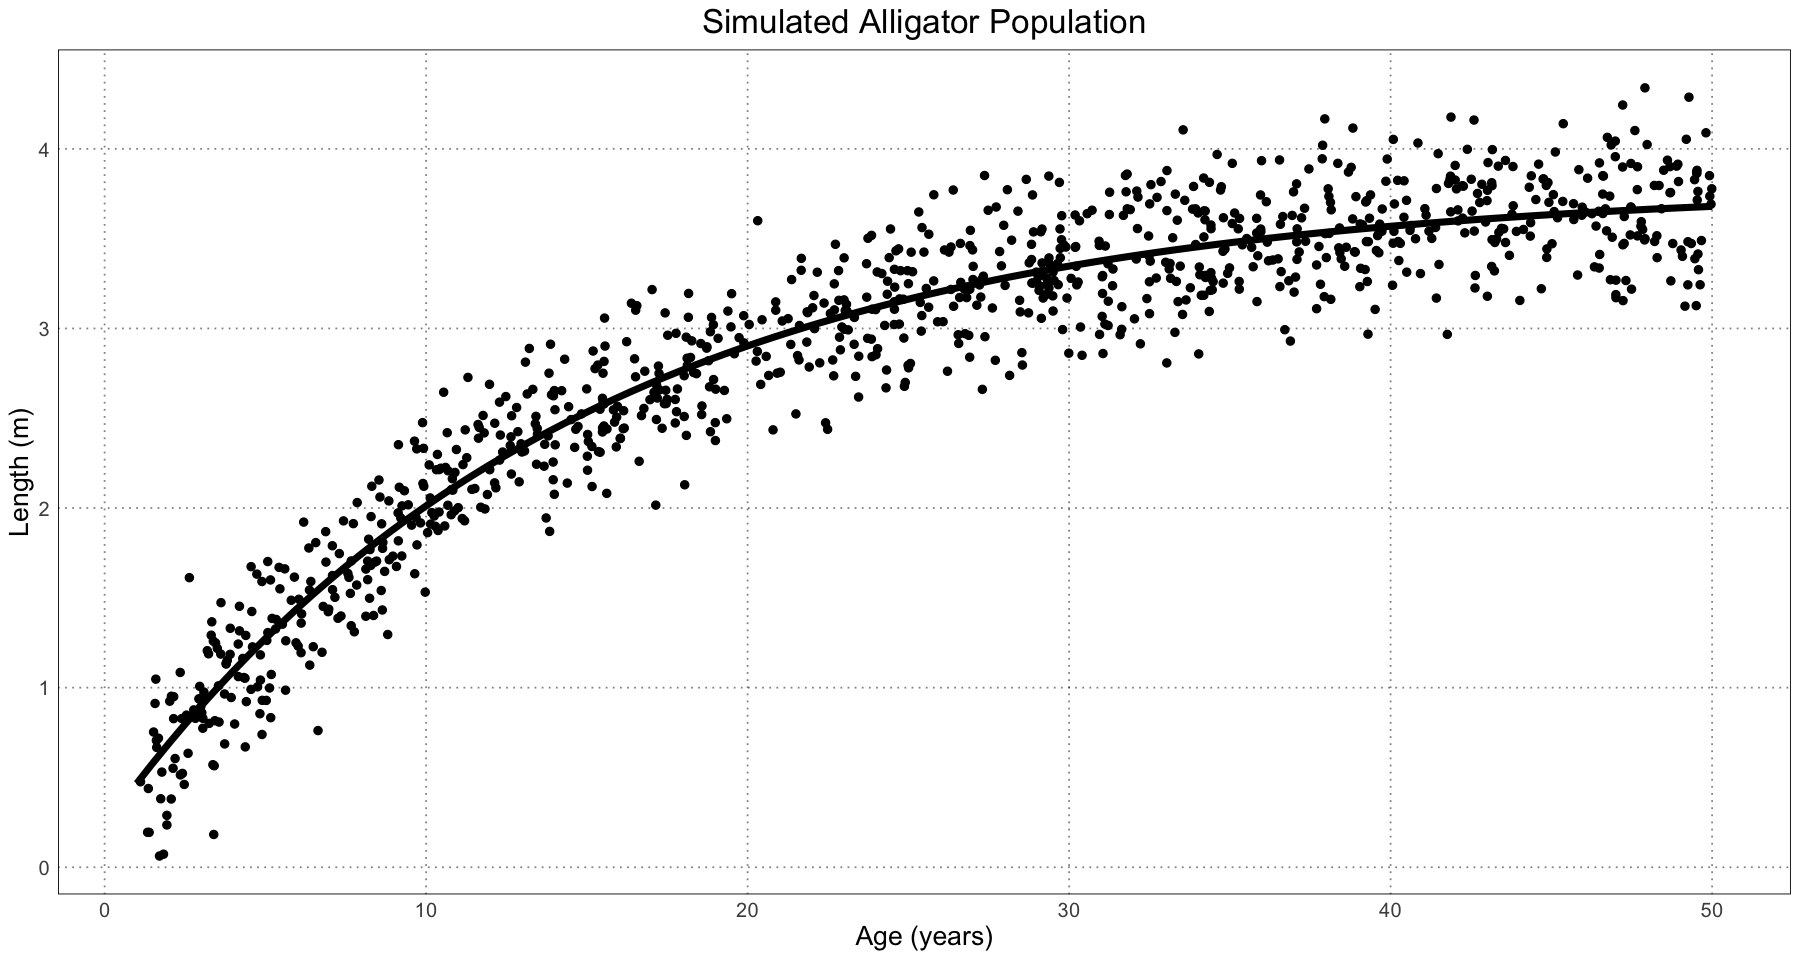

In [4]:
curve_age <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 100)
curve_length <- generalized_von_bertalanffy(curve_age, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
curve_data <- data.frame(age = curve_age, length = curve_length)

ggplot(combined_data, aes(age, length)) +
    geom_point(size = 2) +
    geom_line(data = curve_data, mapping = aes(age, length), linewidth = 2) +
    labs(x = "Age (years)", y = "Length (m)", title = "Simulated Alligator Population") +
    custom_theme()

Great! So now let's build a model for this to ensure that we can recover our initial values.

In [5]:
actual_male_params

$L
[1] 3.79

$A
[1] 0.94

$K
[1] 0.0695

In [6]:
toy_model <- "
data {
    int<lower = 0> N; // number of samples
    vector[N] length; // a vector of the lengths
    vector[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])
}

parameters {
    real<lower = 0> L;
    real<lower = 0> A;
    real<lower = 0> K;
    real<lower = 0> sigma_length;
}

model {
    vector[N] mean_length;

    L ~ normal(3.79, 1);
    K ~ normal(0.0695, 0.05);
    A ~ normal(0.94, 0.5);
    sigma_length ~ normal(0.25, 0.125);
    mean_length = L * (1 - A * exp(-K * age));
    length ~ normal(mean_length, sigma_length);
}

generated quantities {
    real prior_L = normal_rng(3.79, 1);
    real prior_K = normal_rng(0.0695, 0.05);
    real prior_A = normal_rng(0.94, 0.5);
    real prior_sigma_length = normal_rng(0.25, 0.125);
}
"

data <- list(
    N = nrow(combined_data),
    length = combined_data$length,
    age = combined_data$age
)
model.toy <- stan(model_code = toy_model, data = data)

One thing to note is that I've added the priors to the `generated quantities` section so that we can see how we change between the posterior and the prior.

In [7]:
model.toy

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
L                    3.80    0.00 0.02   3.75   3.78   3.80   3.81   3.85  1478
A                    0.95    0.00 0.01   0.93   0.94   0.95   0.96   0.97  1605
K                    0.07    0.00 0.00   0.07   0.07   0.07   0.07   0.07  1227
sigma_length         0.26    0.00 0.01   0.24   0.25   0.26   0.26   0.27  2019
prior_L              3.82    0.02 0.99   1.85   3.15   3.82   4.50   5.71  4071
prior_K              0.07    0.00 0.05  -0.03   0.04   0.07   0.10   0.17  3907
prior_A              0.94    0.01 0.51  -0.05   0.60   0.94   1.29   1.94  4031
prior_sigma_length   0.25    0.00 0.13   0.00   0.17   0.25   0.34   0.50  4104
lp__               861.19    0.03 1.40 857.66 860.49 861.49 862.22 862.96  1677
                   Rhat
L                   

Looking at the rhat, it looks like we had good convergence. Now let's take a look at the distribution for the values of the parameters and compare them to the original ones.

In [8]:
samples <- extract(model.toy)
lapply(samples, head)

$L
[1] 3.785752 3.818689 3.797218 3.803179 3.737567 3.806371

$A
[1] 0.9576397 0.9571667 0.9427428 0.9534937 0.9738206 0.9436346

$K
[1] 0.07149532 0.06932364 0.06916491 0.06853217 0.07461194 0.06846608

$sigma_length
[1] 0.2560555 0.2452110 0.2541219 0.2565700 0.2571118 0.2520569

$prior_L
[1] 2.682089 2.907450 2.418919 3.857775 3.855572 2.971949

$prior_K
[1]  0.044585694  0.167610656  0.091258637  0.001463860 -0.004266231
[6]  0.067929647

$prior_A
[1] 2.0223453 1.8819153 0.2952470 0.4573121 1.1947028 0.6151195

$prior_sigma_length
[1] 0.4438525 0.3856819 0.1980231 0.4416391 0.2273161 0.3483890

$lp__
[1] 862.2270 859.8478 862.9925 861.0670 859.5185 862.7993

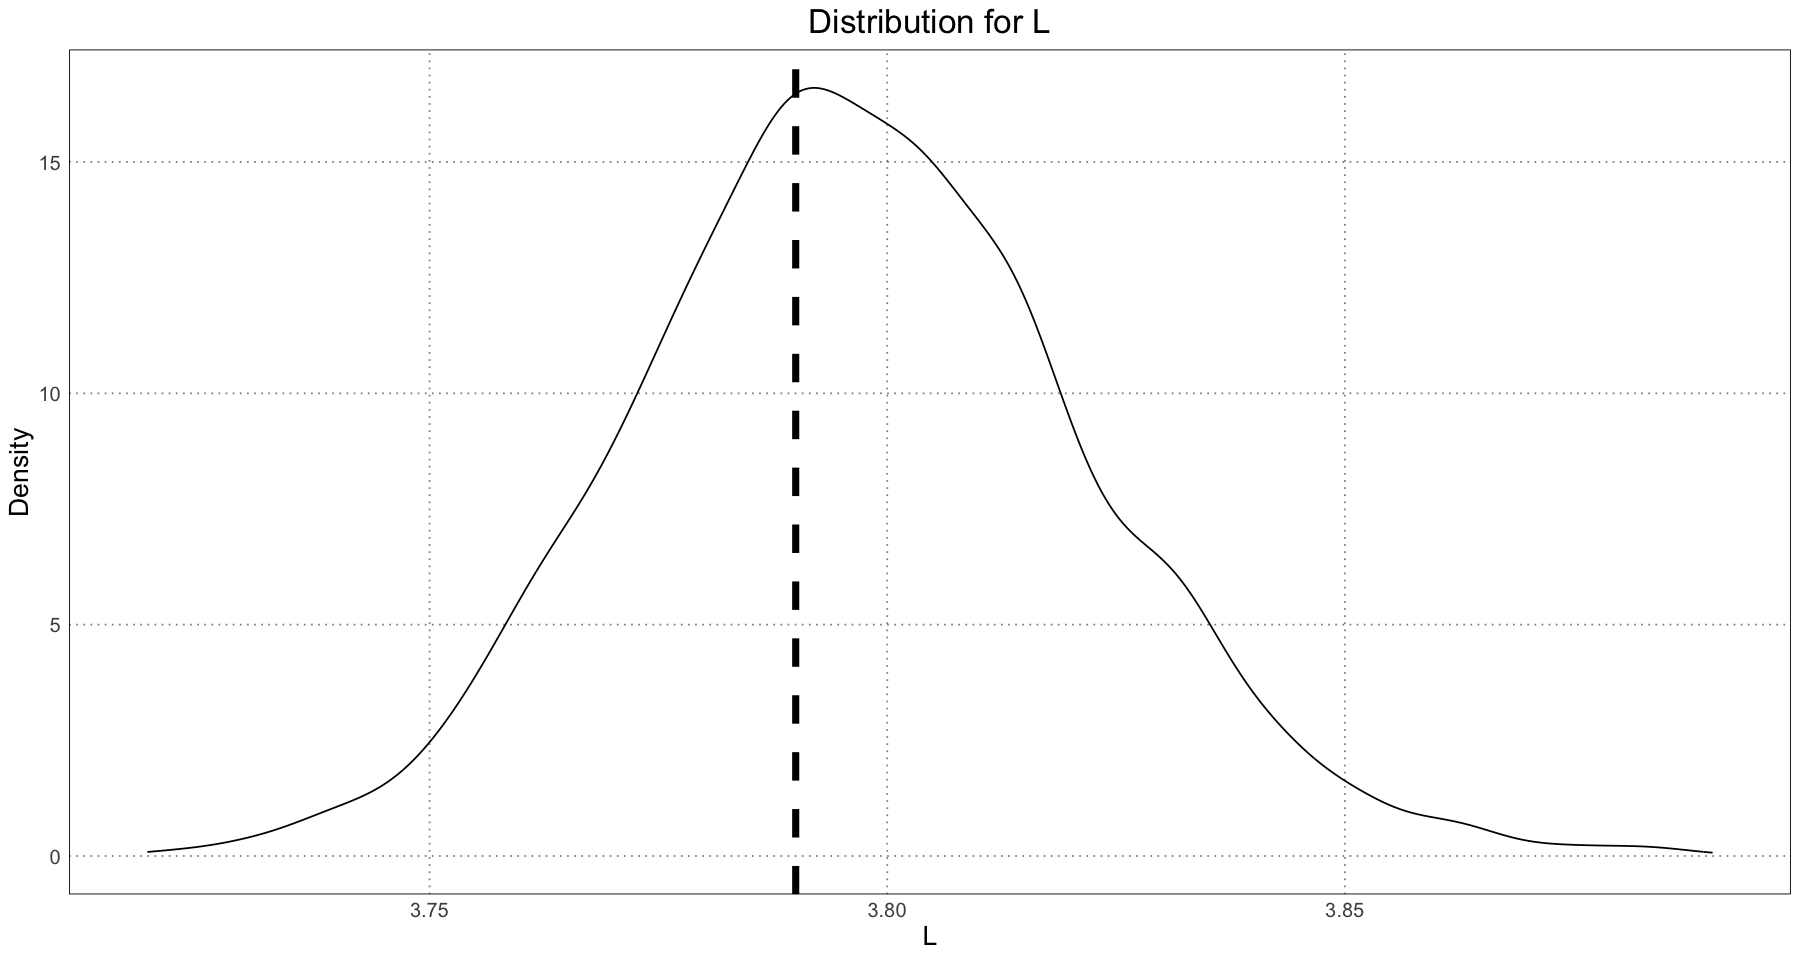

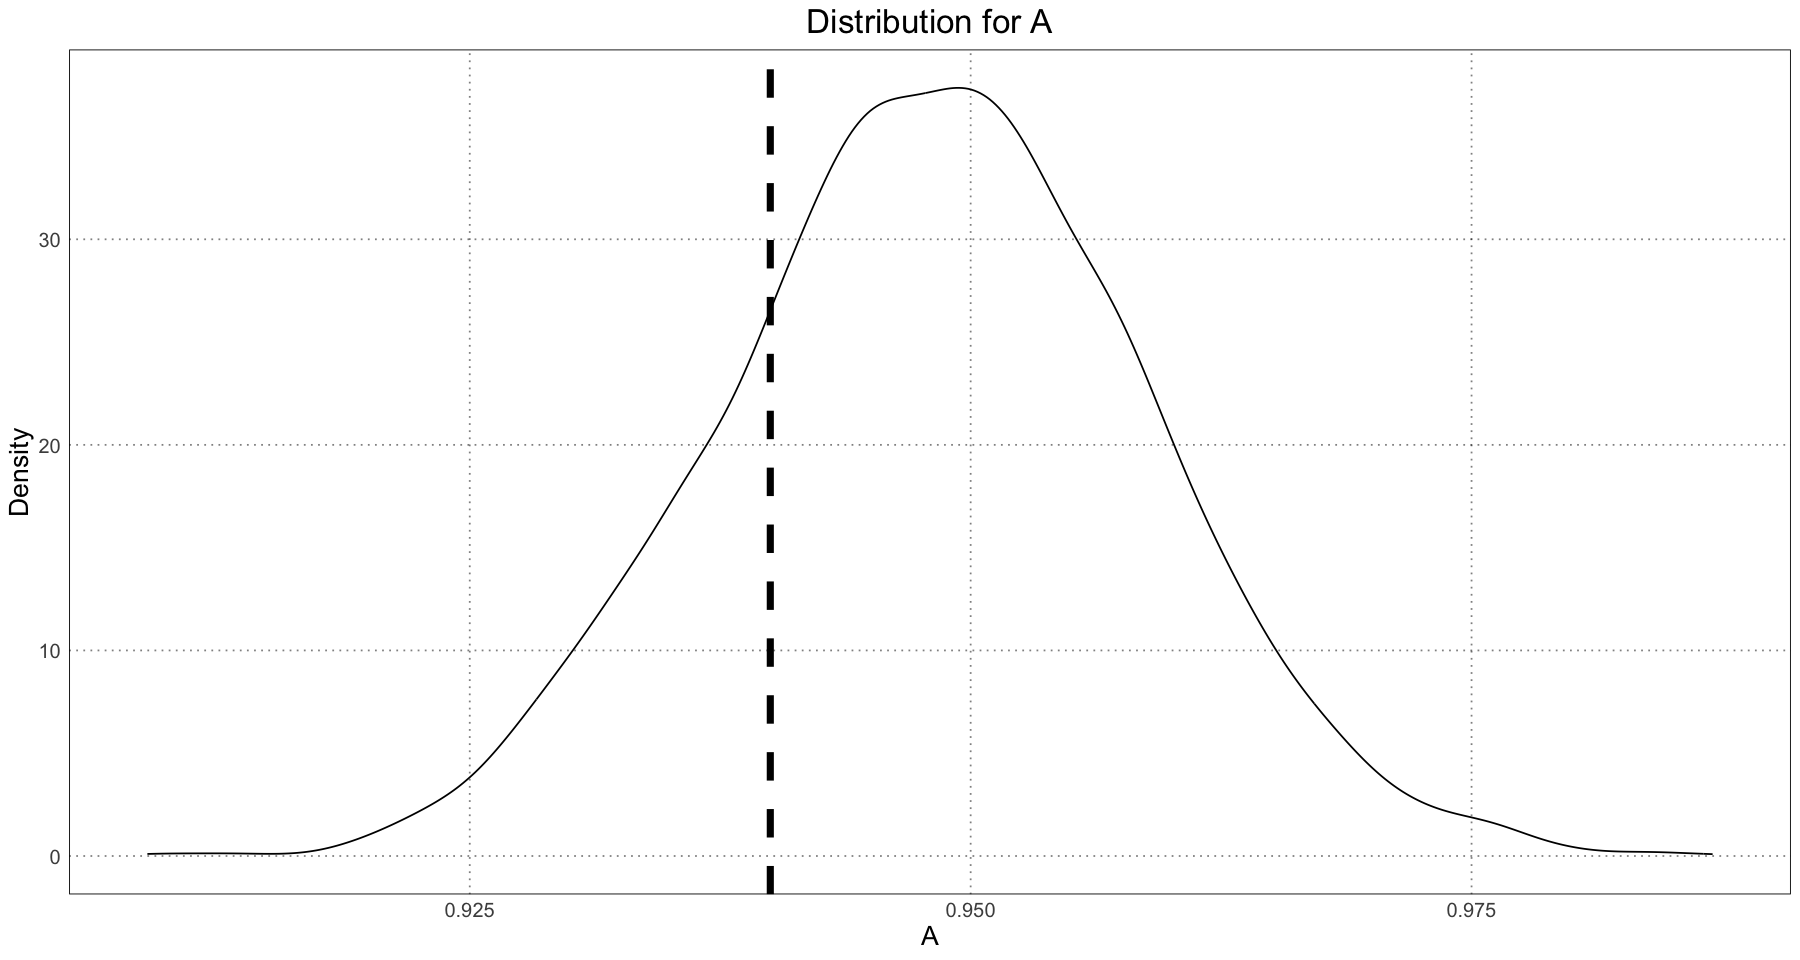

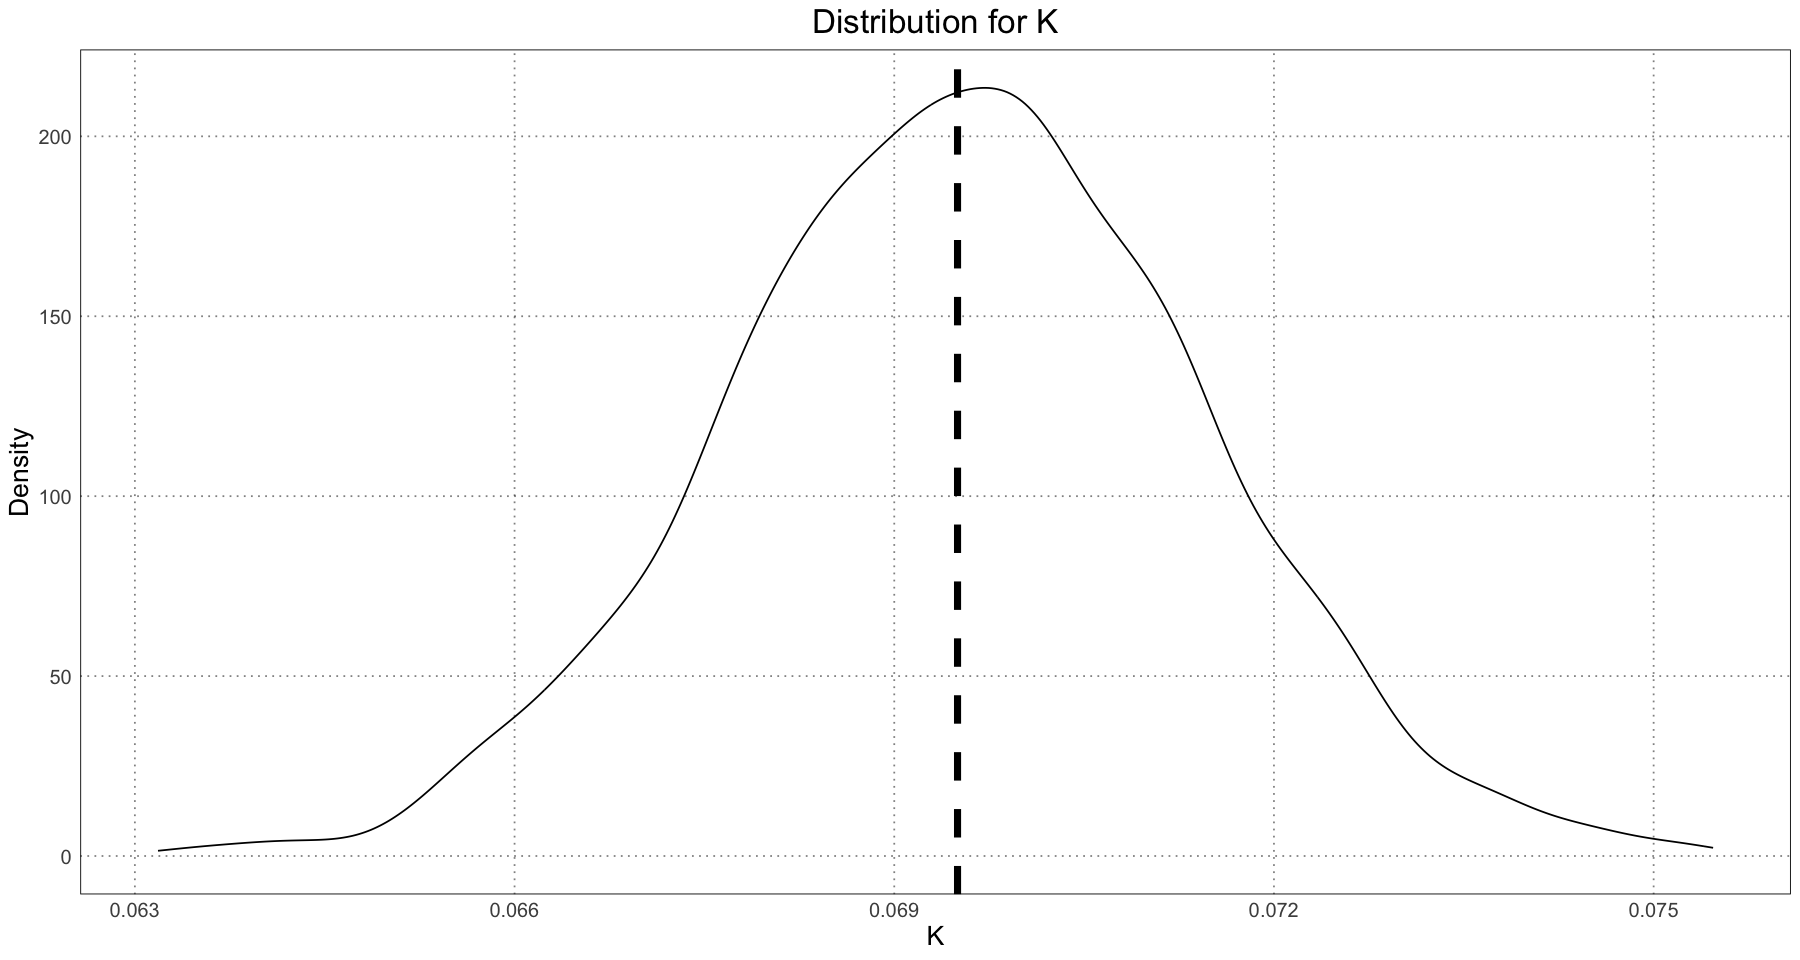

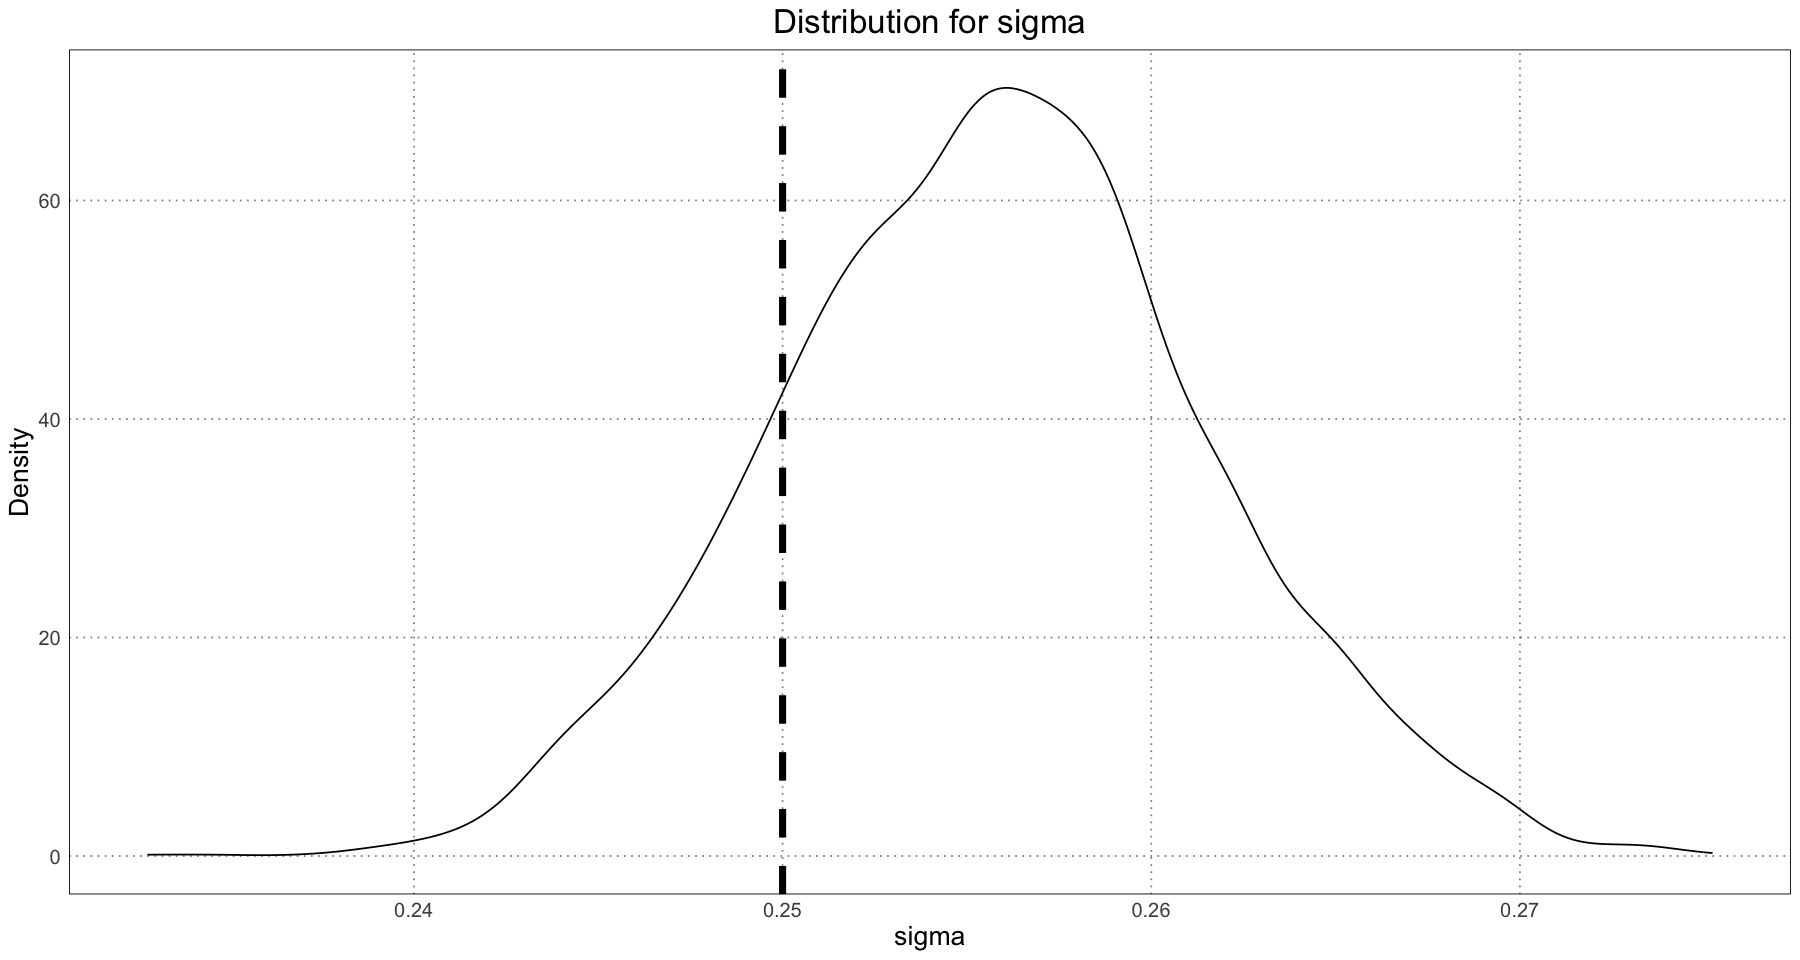

In [9]:
ggplot(data.frame(x = samples[['L']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "L", y = "Density", title = "Distribution for L") +
    custom_theme()
ggplot(data.frame(x = samples[['A']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['A']], linewidth = 2, linetype = 'dashed') +
    labs(x = "A", y = "Density", title = "Distribution for A") +
    custom_theme()
ggplot(data.frame(x = samples[['K']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['K']], linewidth = 2, linetype = 'dashed') +
    labs(x = "K", y = "Density", title = "Distribution for K") +
    custom_theme()
ggplot(data.frame(x = samples[['sigma_length']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = sigma, linewidth = 2, linetype = 'dashed') +
    labs(x = "sigma", y = "Density", title = "Distribution for sigma") +
    custom_theme()

Now the priors:

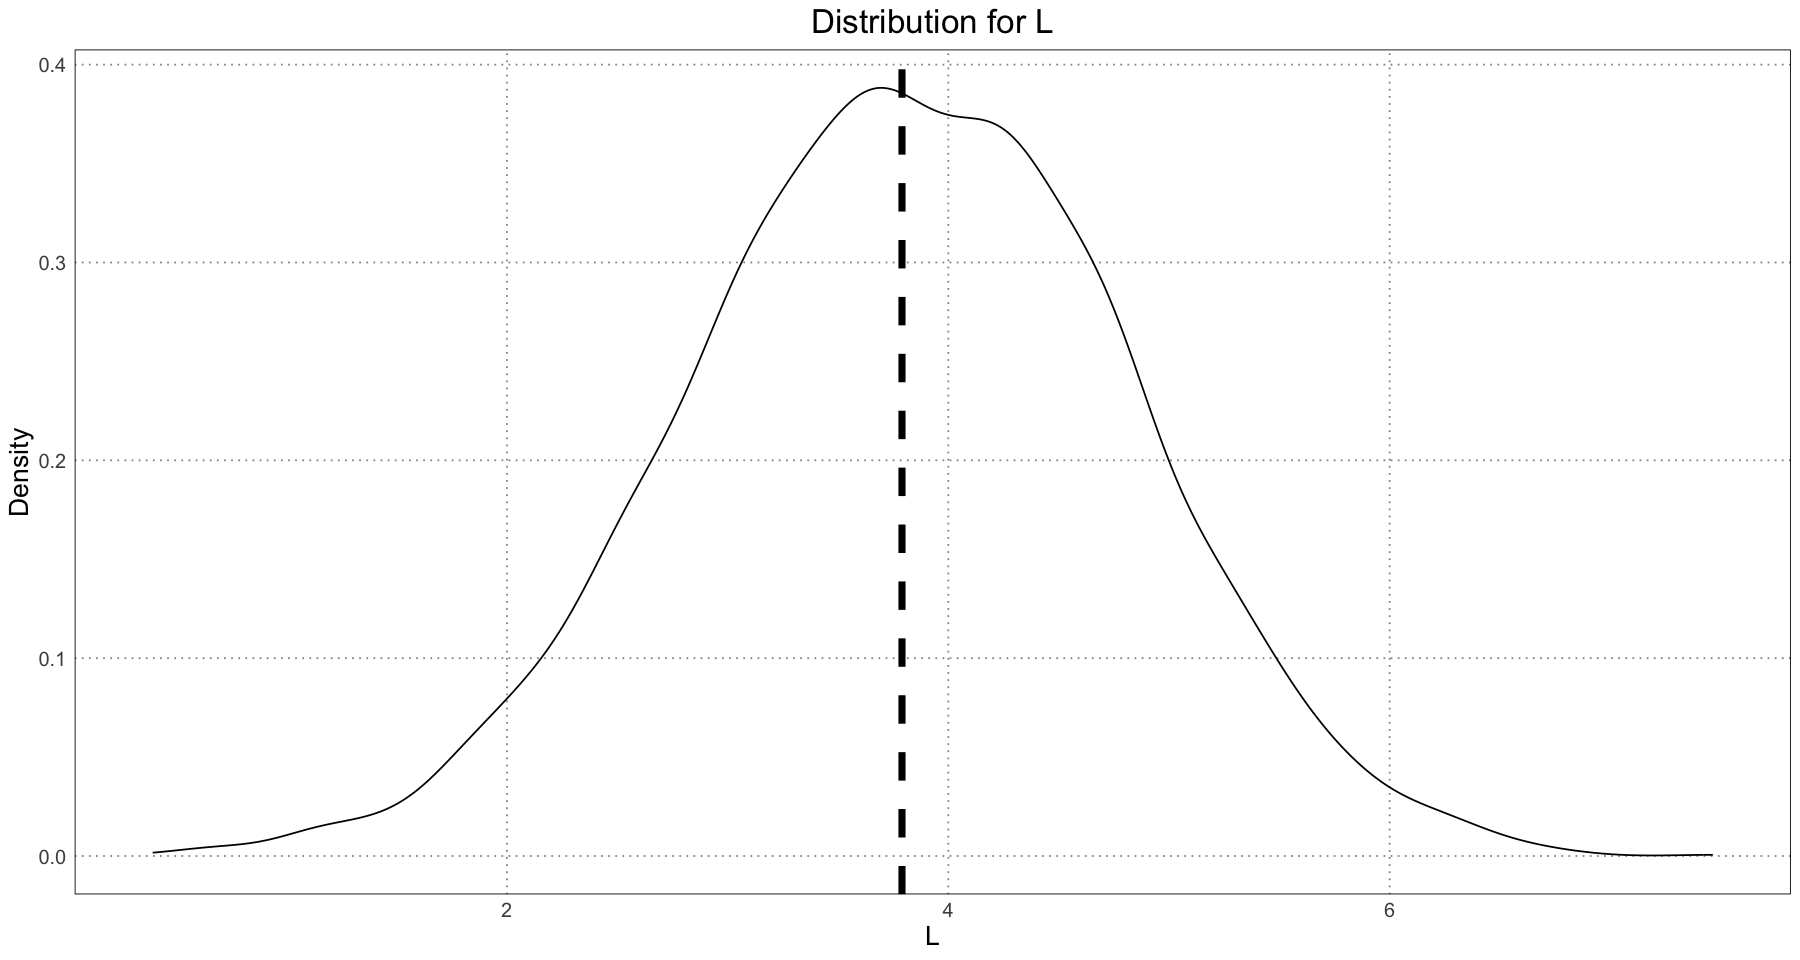

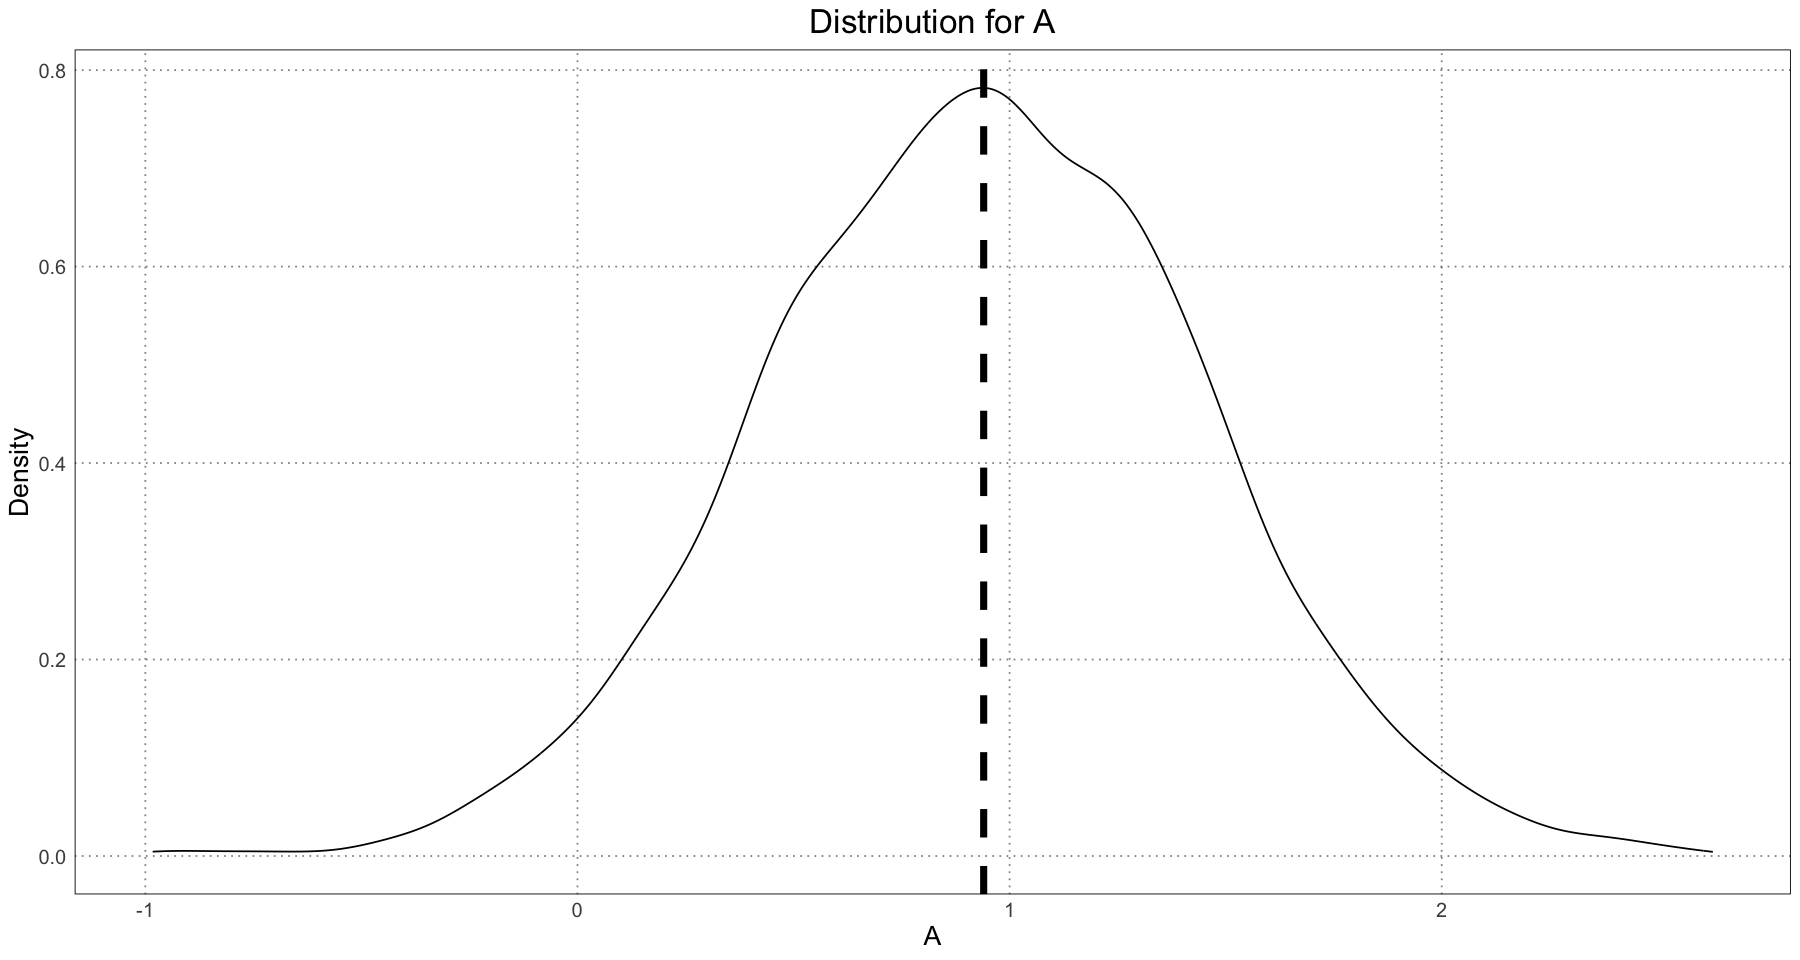

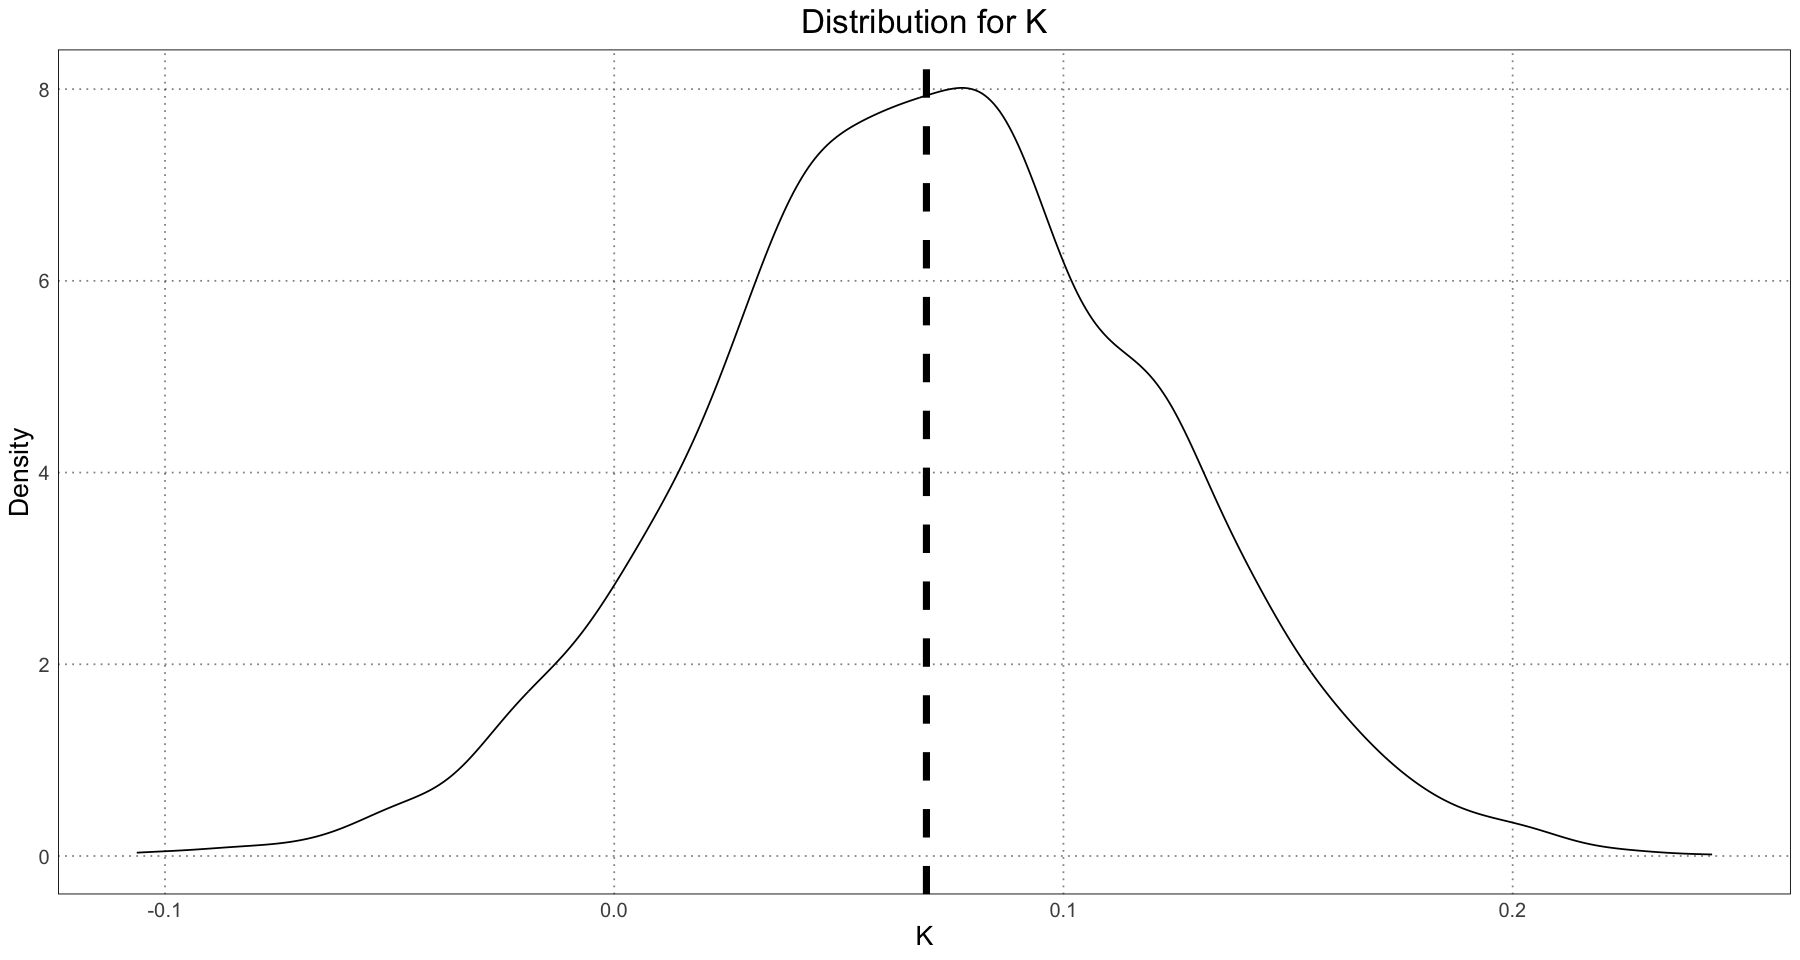

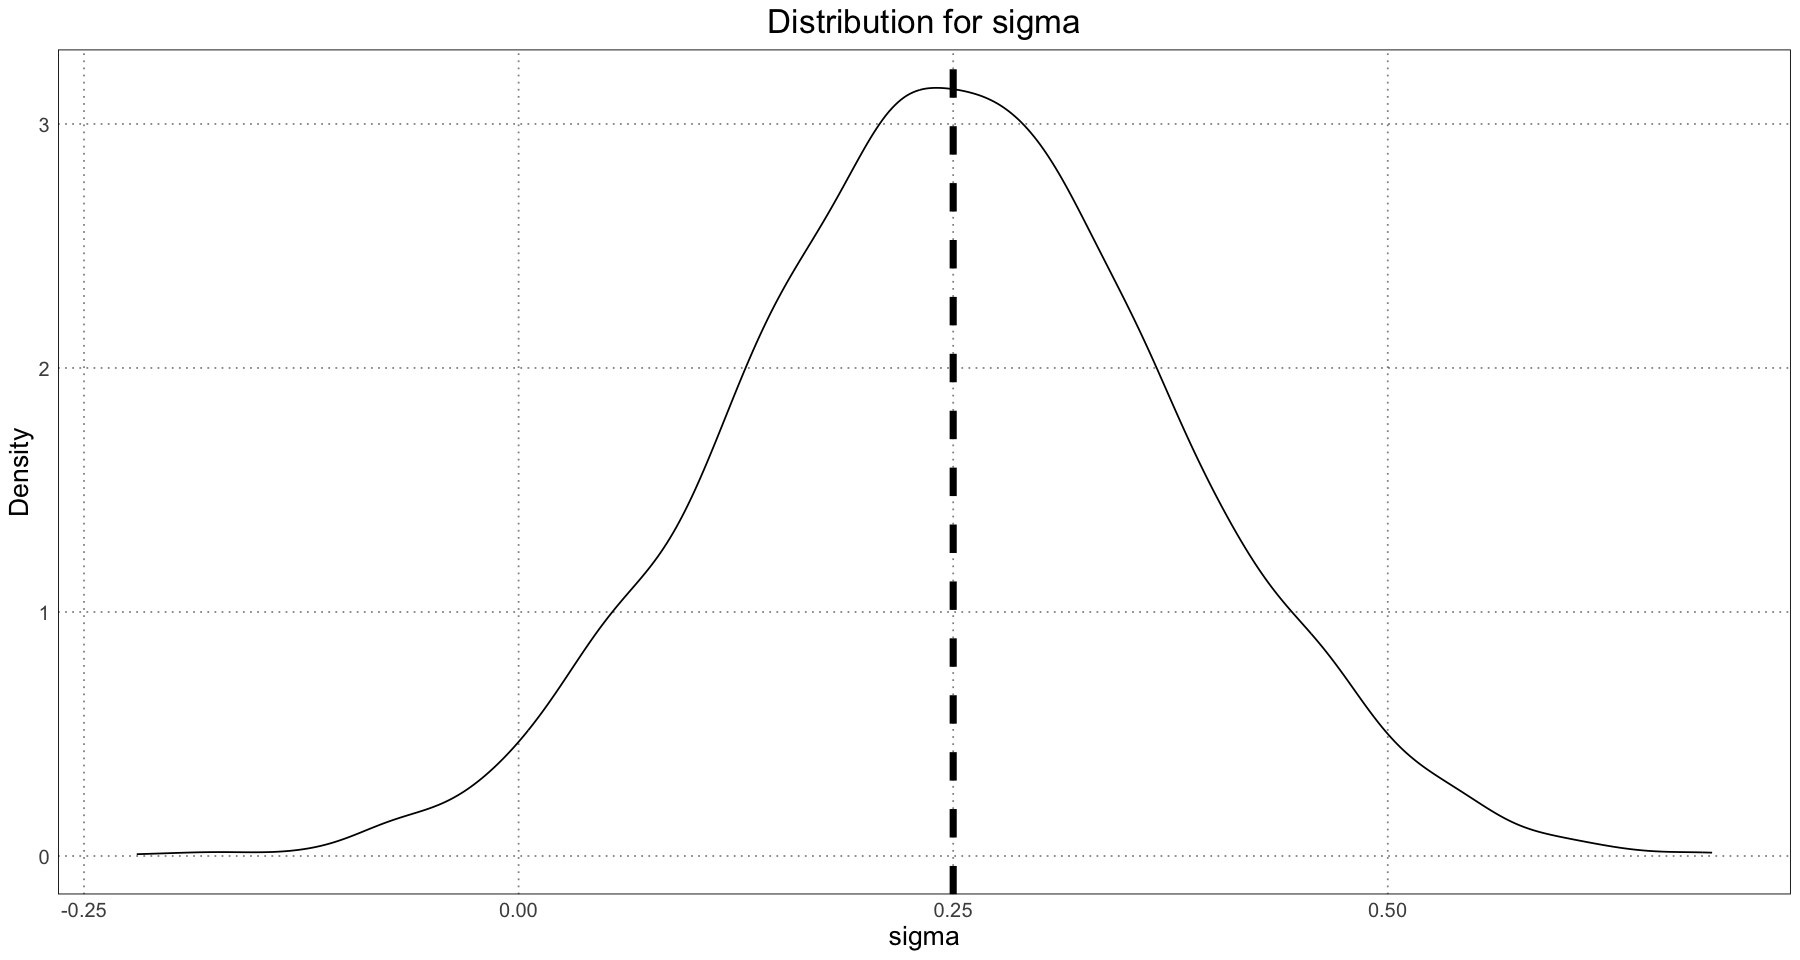

In [10]:
ggplot(data.frame(x = samples[['prior_L']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "L", y = "Density", title = "Distribution for L") +
    custom_theme()
ggplot(data.frame(x = samples[['prior_A']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['A']], linewidth = 2, linetype = 'dashed') +
    labs(x = "A", y = "Density", title = "Distribution for A") +
    custom_theme()
ggplot(data.frame(x = samples[['prior_K']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['K']], linewidth = 2, linetype = 'dashed') +
    labs(x = "K", y = "Density", title = "Distribution for K") +
    custom_theme()
ggplot(data.frame(x = samples[['prior_sigma_length']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = sigma, linewidth = 2, linetype = 'dashed') +
    labs(x = "sigma", y = "Density", title = "Distribution for sigma") +
    custom_theme()

Posterior and prior:

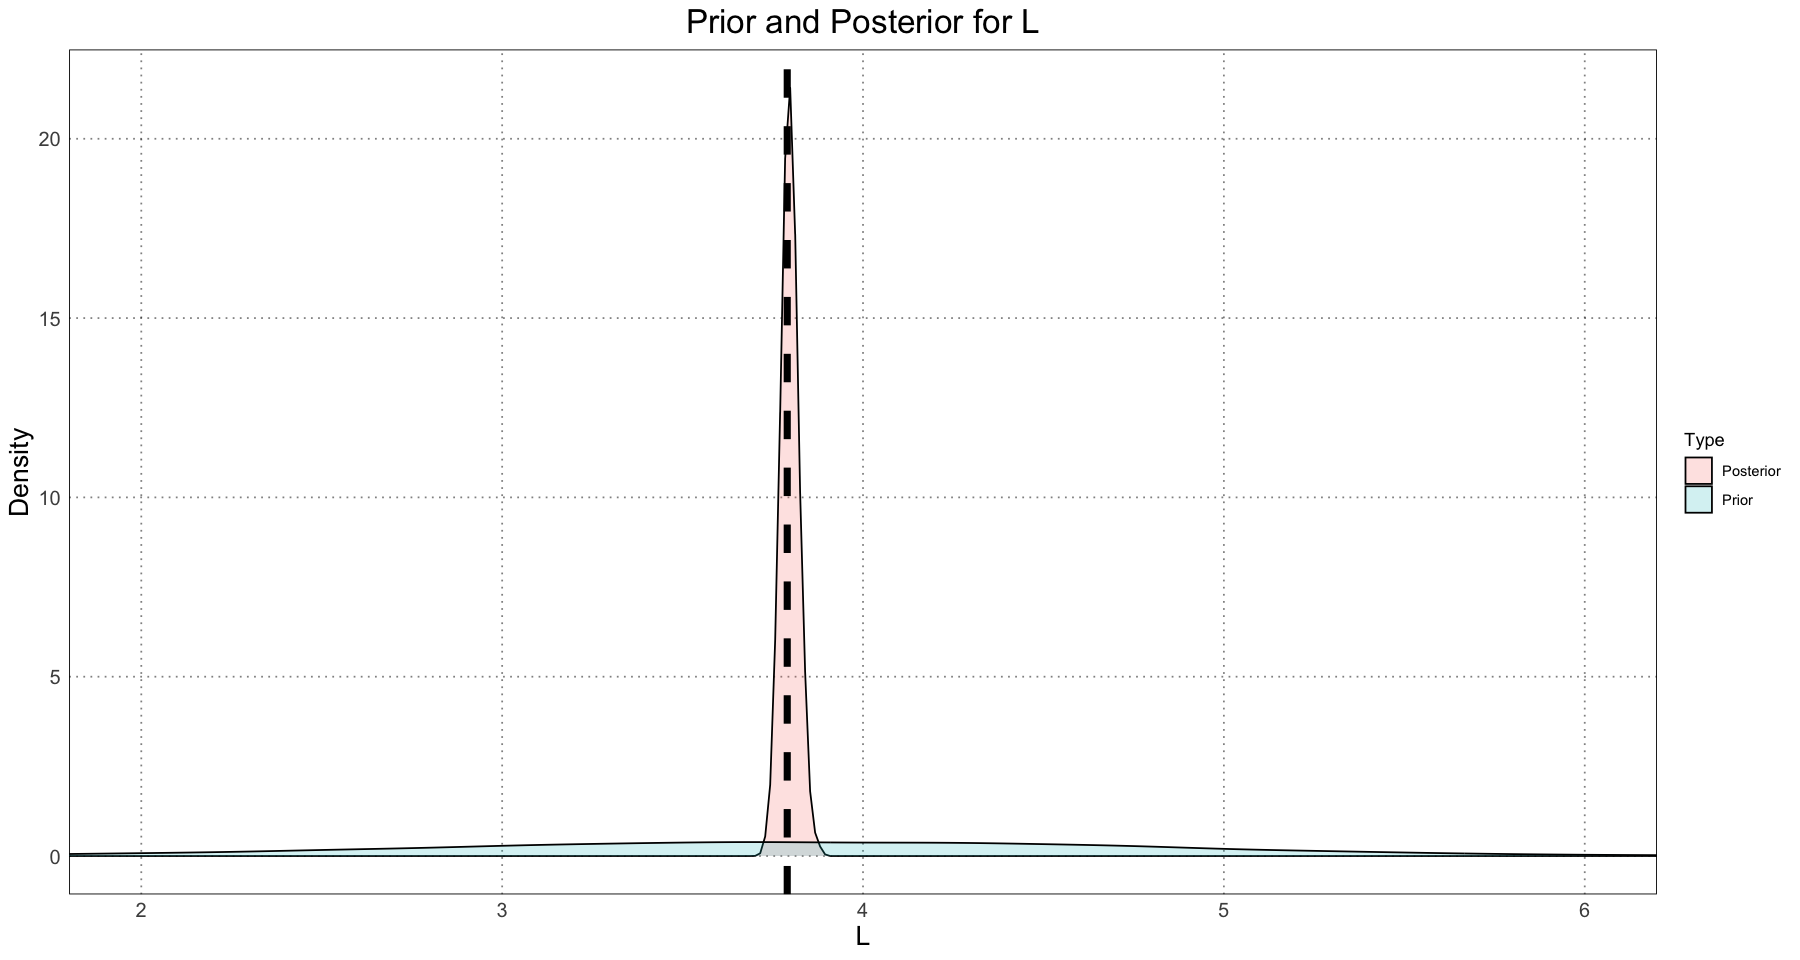

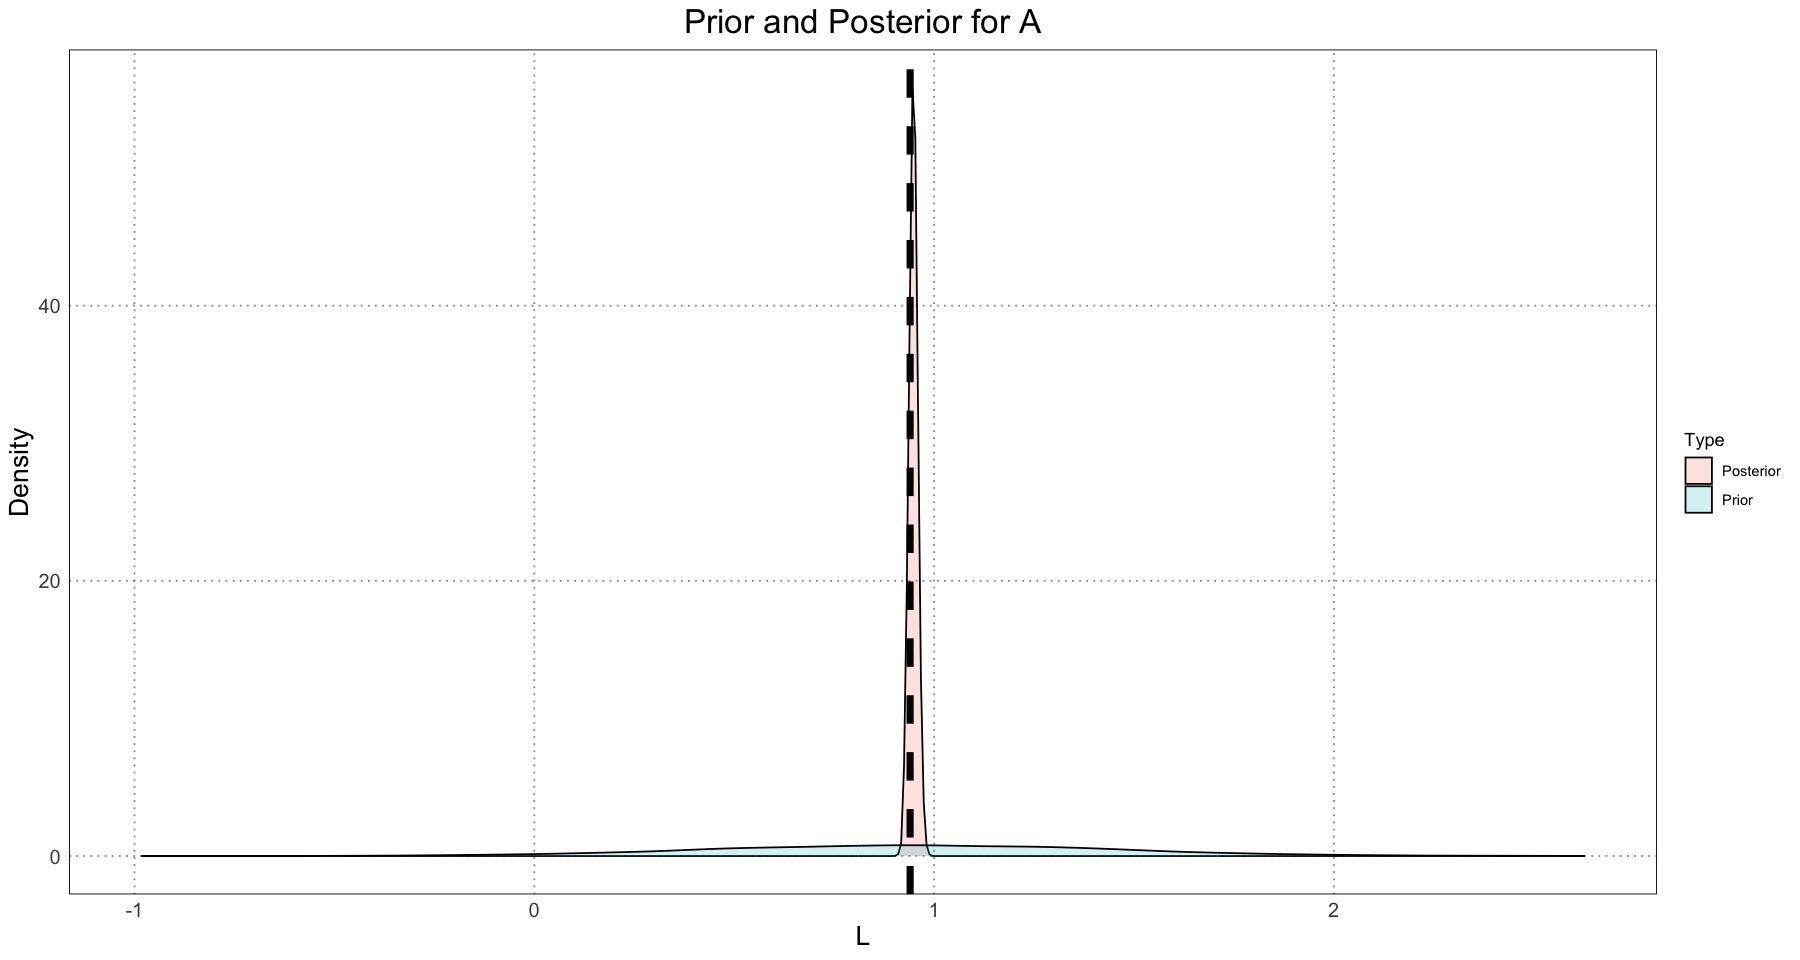

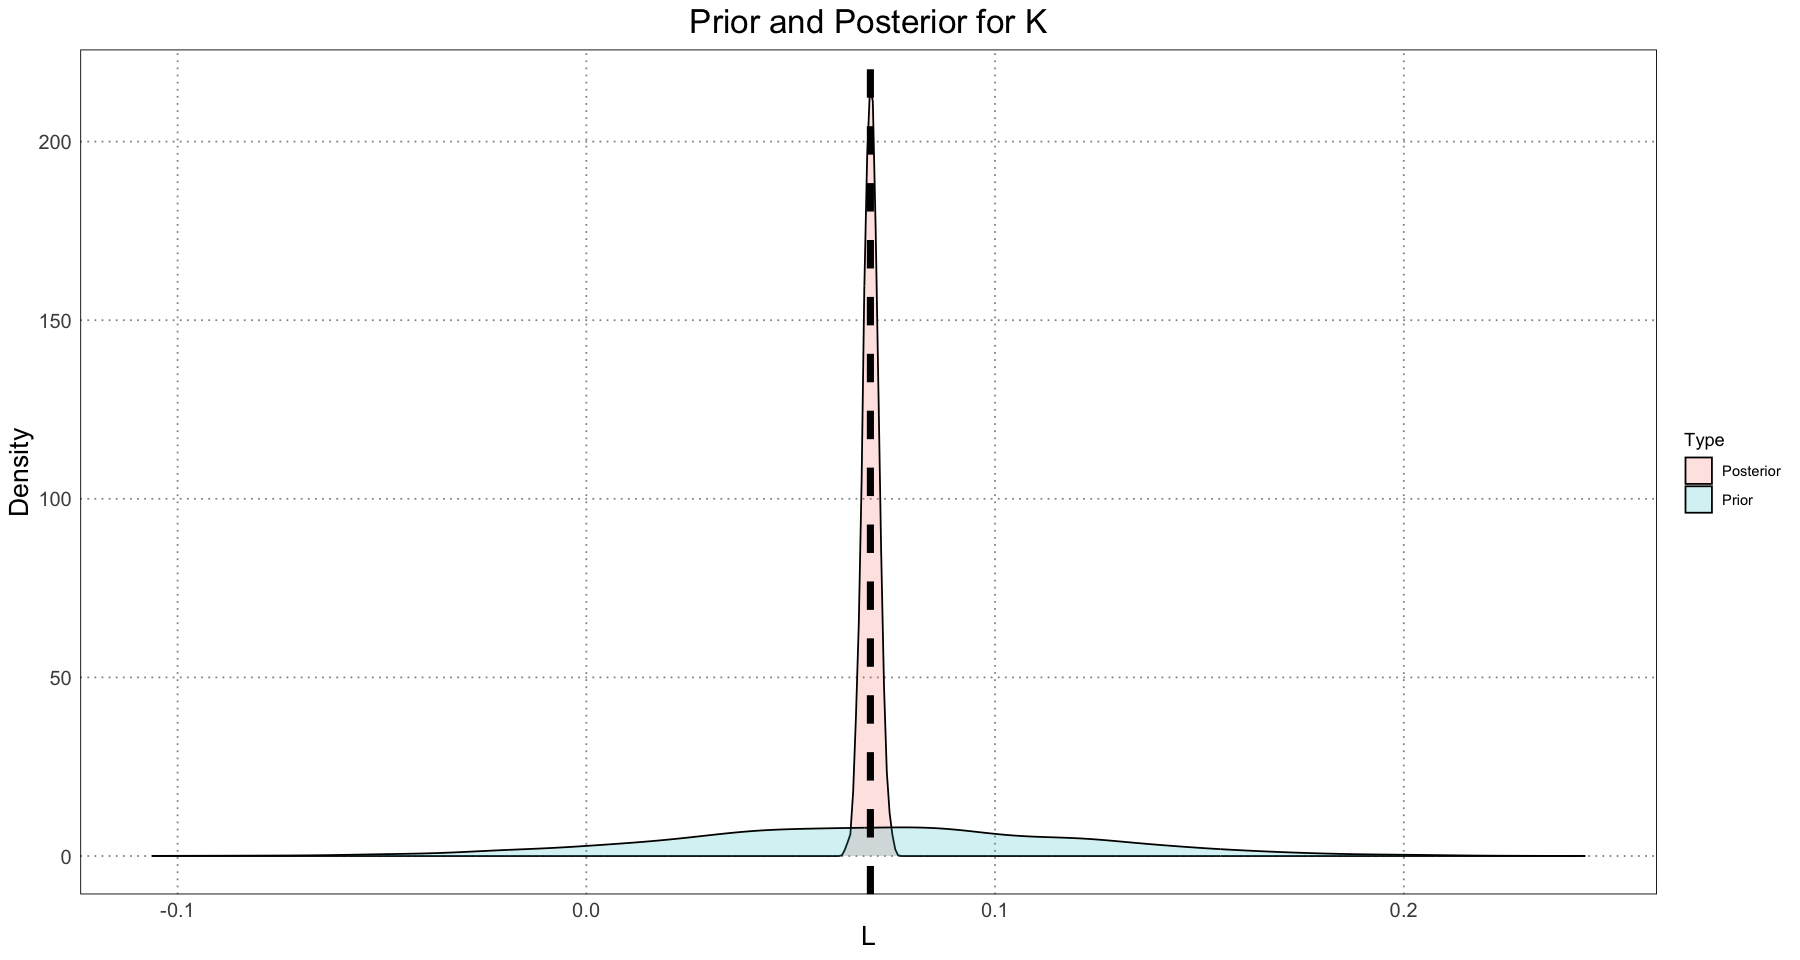

In [11]:
prior_and_posterior <- rbind(
    data.frame(x = samples[['L']], type="Posterior"),
    data.frame(x = samples[['prior_L']], type="Prior")
)
ggplot(prior_and_posterior, aes(x, group = type, fill = type)) +
    geom_density(aes(y = after_stat(density)), alpha = 0.2) +
    labs(x = "L", y = "Density", title = "Prior and Posterior for L", fill = "Type") +
    geom_vline(xintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    coord_cartesian(xlim = c(2, 6)) +
    custom_theme()

prior_and_posterior <- rbind(
    data.frame(x = samples[['A']], type="Posterior"),
    data.frame(x = samples[['prior_A']], type="Prior")
)
ggplot(prior_and_posterior, aes(x, group = type, fill = type)) +
    geom_density(aes(y = after_stat(density)), alpha = 0.2) +
    labs(x = "A", y = "Density", title = "Prior and Posterior for A", fill = "Type") +
    geom_vline(xintercept = actual_male_params[['A']], linewidth = 2, linetype = 'dashed') +
    custom_theme()

prior_and_posterior <- rbind(
    data.frame(x = samples[['K']], type="Posterior"),
    data.frame(x = samples[['prior_K']], type="Prior")
)
ggplot(prior_and_posterior, aes(x, group = type, fill = type)) +
    geom_density(aes(y = after_stat(density)), alpha = 0.2) +
    labs(x = "K", y = "Density", title = "Prior and Posterior for K", fill = "Type") +
    geom_vline(xintercept = actual_male_params[['K']], linewidth = 2, linetype = 'dashed') +
    custom_theme()

A few things are immediately clear:
1. Our posterior estimate is pretty good
1. Our priors were ridiculously wide

In fact, the priors are so wide the they almost don't make sense. For instance, let's plot the actual curve against a selection of curves drawn from the prior distribution.

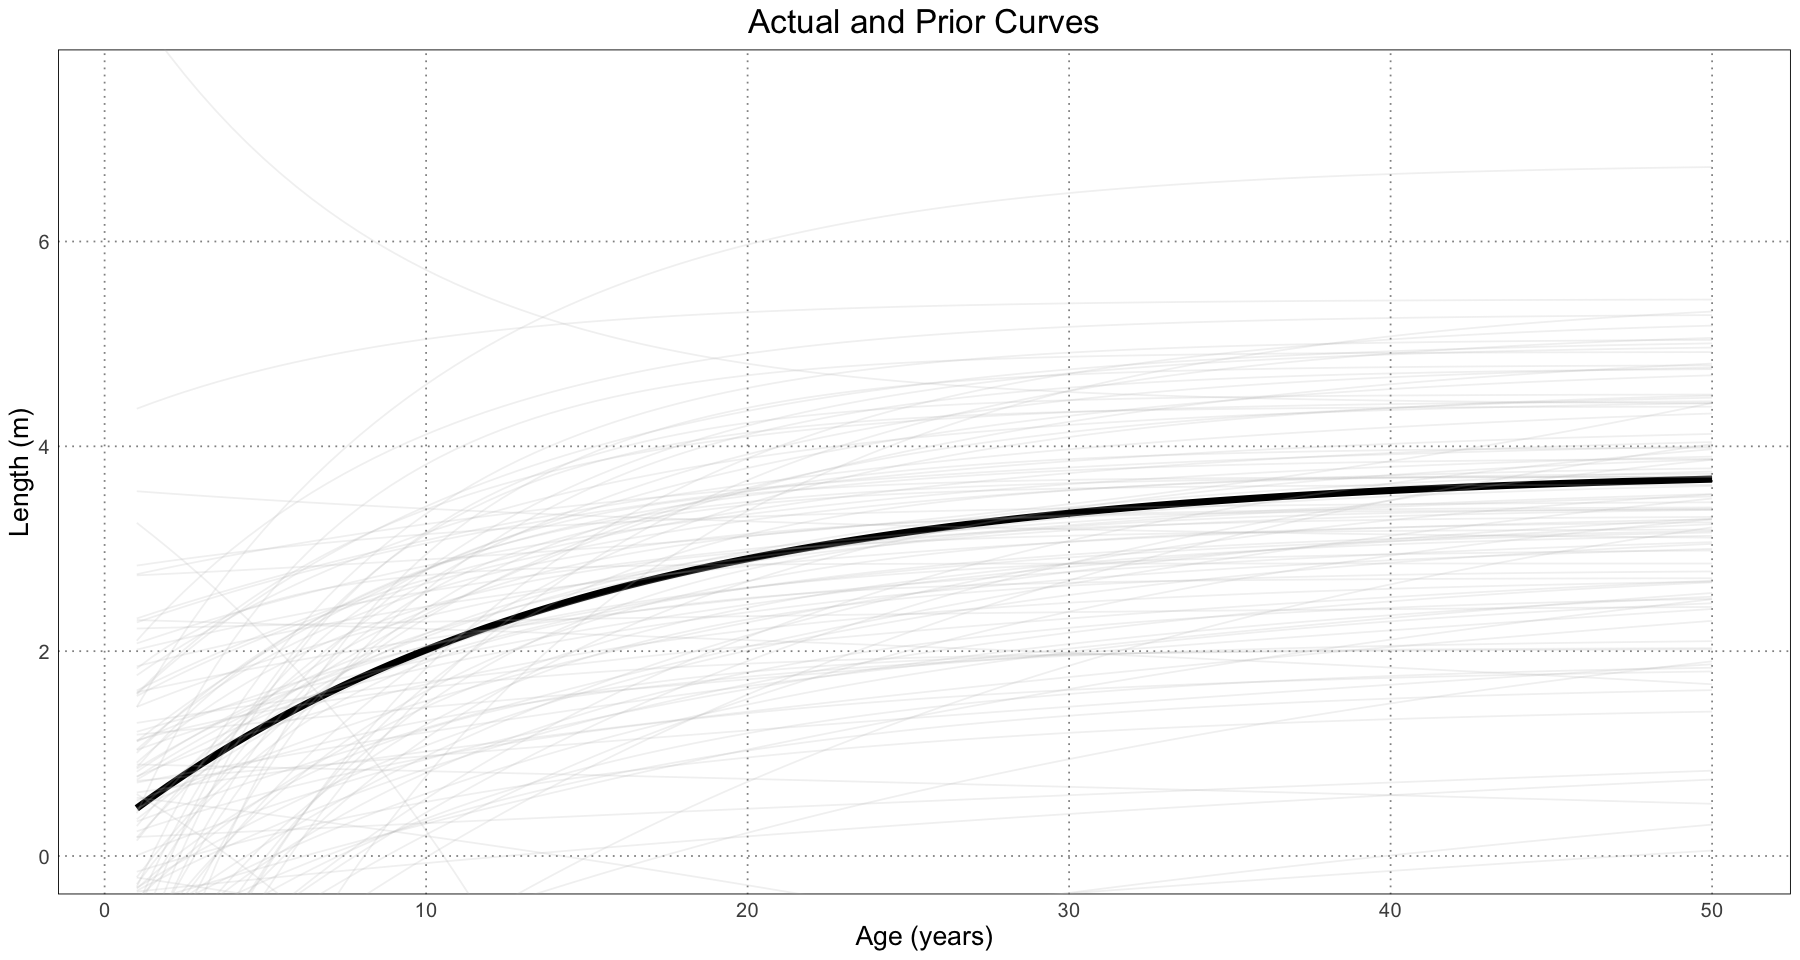

In [12]:
curve_ages <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 100)
actual_curve_lengths <- generalized_von_bertalanffy(curve_ages,L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])

curve_data <- data.frame(age = curve_ages, length = actual_curve_lengths)

p <- ggplot(curve_data, aes(age, length)) +
    geom_line(linewidth = 2) +
    labs(x = "Age (years)", y = "Length (m)", title = "Actual and Prior Curves") +
    coord_cartesian(ylim = c(0, 7.5)) +
    custom_theme()

for (i in 1:100) {
    sample_index <- sample(1:length(samples[['L']]), 1)
    L <- samples[['prior_L']][sample_index]
    A <- samples[['prior_A']][sample_index]
    K <- samples[['prior_K']][sample_index]
    prior_curve_length <- generalized_von_bertalanffy(curve_ages, L = L, A = A, K = K)
    prior_data <- data.frame(age = curve_age, length = prior_curve_length)
    p <- p + 
        geom_line(data = prior_data, mapping = aes(age, length), colour = 'grey', alpha = 0.2)
}
print(p)

As you can see, we are basically saying that we have very little idea how alligators grow.

By contrast, let's see how the posterior distributions look in the same graph.

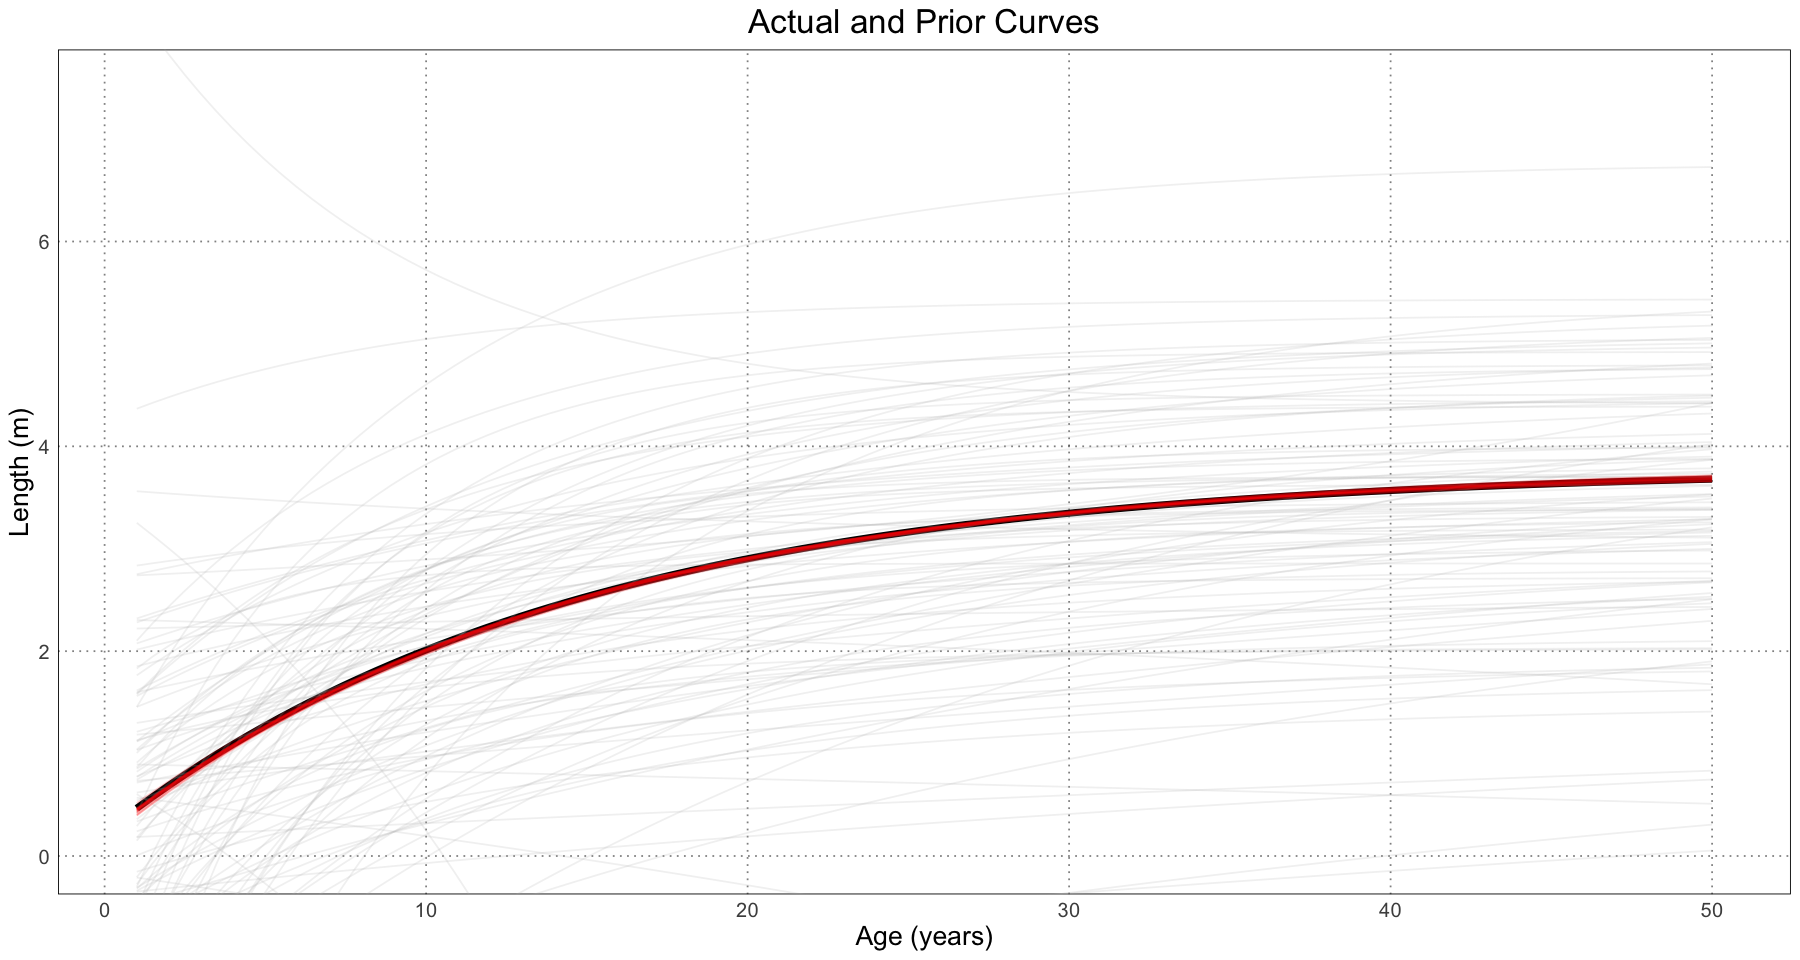

In [13]:
for (i in 1:20) {
    sample_index <- sample(1:length(samples[['L']]), 1)
    L <- samples[['L']][sample_index]
    A <- samples[['A']][sample_index]
    K <- samples[['K']][sample_index]
    prior_curve_length <- generalized_von_bertalanffy(curve_ages, L = L, A = A, K = K)
    prior_data <- data.frame(age = curve_age, length = prior_curve_length)
    p <- p + 
        geom_line(data = prior_data, mapping = aes(age, length), colour = 'red', alpha = 0.2)
}
print(p)

As you see, the posteriors are all tightly clstered around the actual curve, as we expect.

For now we're going to ignore the issue of the priors. We are certainly going to have to reexamine them later, once we start looking at cases where there are fewer pieces of data. That's because the influence of the priors in this case (with lots of samples) is quite minimal, whereas with fewer pieces of data the influce will increase.

Next, let's see if we can extract the distribution of the posterior level of sexual dimorphism, $L_m - L_f$. For this, we're going to have to fit separate curves to the male and female alligators and then look at the distribution of the differences in this parameter. Again, to keep things slightly simpler I'm going to ignore the dependence of the standard deviation $\sigma$ on the mean length,just keeping it as a constant for now.

In [14]:
num_samples <- 1e3
test_ages <- runif(num_samples, 1, ALLIGATOR_MAX_LIFESPAN)
sigma <- 0.25

female_lengths_mean <- generalized_von_bertalanffy(test_ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])
female_lengths <- rnorm(num_samples, mean = female_lengths_mean, sd = sigma)

male_lengths_mean <- generalized_von_bertalanffy(test_ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
male_lengths <- rnorm(num_samples, mean = male_lengths_mean, sd = sigma)

# fit a curve to the whole population to use as a prior
population_data <- data.frame(
    age = rep(test_ages, 2),
    length = c(female_lengths, male_lengths),
    sex = rep(c("F", "M"), each = length(test_ages))
)
fit.population <- nlsLM(length ~ generalized_von_bertalanffy(age, L, A, K), data = population_data, start = generate_initial_vb_params(population_data))
fit.population

Nonlinear regression model
  model: length ~ generalized_von_bertalanffy(age, L, A, K)
   data: population_data
      L       K       A 
3.27965 0.07758 0.92040 
 residual sum-of-squares: 328.5

Number of iterations to convergence: 4 
Achieved convergence tolerance: 1.49e-08

In [15]:
coef(fit.population)

L          K          A 
3.27964949 0.07757913 0.92040426

We're now going to build a model where the prior is a loose cluster around the population values and apply that to the male and female samples. Then we'll look at the distribution of the difference in their $L$ parameters. Note that these values are taken from one particular run / sample - they will be slightly different for each one.

In [23]:
population_prior_model <- "
data {
    int<lower = 0> N; // number of samples
    vector[N] length; // a vector of the lengths
    vector[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])
}

parameters {
    real<lower = 0> L;
    real<lower = 0> A;
    real<lower = 0> K;
    real<lower = 0> sigma_length;
}

model {
    vector[N] mean_length;

    L ~ normal(3.280, 0.5);
    K ~ normal(0.0779, 0.025);
    A ~ normal(0.92, 0.25);
    sigma_length ~ normal(0.25, 0.0625);
    mean_length = L * (1 - A * exp(-K * age));
    length ~ normal(mean_length, sigma_length);
}

generated quantities {
    real prior_L = normal_rng(3.280, 0.5);
    real prior_K = normal_rng(0.0779, 0.025);
    real prior_A = normal_rng(0.92, 0.25);
    real prior_sigma_length = normal_rng(0.25, 0.0625);
}
"

male_information <- population_data[population_data$sex == "M", ]
male_data <- list(
    N = nrow(male_information),
    age = male_information$age,
    length = male_information$length
)
model.male <- stan(model_code = population_prior_model, data = male_data)
model.male

female_information <- population_data[population_data$sex == "F", ]
female_data <- list(
    N = nrow(female_information),
    age = female_information$age,
    length = female_information$length
)
model.female <- stan(model_code = population_prior_model, data = female_data)
model.female

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
L                    3.80    0.00 0.02   3.76   3.78   3.80   3.82   3.85  1715
A                    0.94    0.00 0.01   0.92   0.93   0.94   0.95   0.96  1705
K                    0.07    0.00 0.00   0.07   0.07   0.07   0.07   0.07  1456
sigma_length         0.24    0.00 0.01   0.23   0.24   0.24   0.25   0.25  2405
prior_L              3.28    0.01 0.50   2.29   2.94   3.28   3.61   4.25  4094
prior_K              0.08    0.00 0.02   0.03   0.06   0.08   0.09   0.13  3642
prior_A              0.92    0.00 0.25   0.45   0.75   0.92   1.09   1.41  3804
prior_sigma_length   0.25    0.00 0.06   0.13   0.21   0.25   0.29   0.37  3868
lp__               907.42    0.04 1.42 903.76 906.77 907.76 908.47 909.17  1624
                   Rhat
L                   

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
L                    2.78    0.00 0.02   2.75   2.77   2.78   2.80   2.82  2254
A                    0.90    0.00 0.02   0.87   0.89   0.90   0.91   0.93  2219
K                    0.09    0.00 0.00   0.09   0.09   0.09   0.09   0.10  1947
sigma_length         0.26    0.00 0.01   0.25   0.25   0.26   0.26   0.27  2387
prior_L              3.27    0.01 0.51   2.30   2.93   3.26   3.62   4.27  3810
prior_K              0.08    0.00 0.03   0.03   0.06   0.08   0.10   0.13  4057
prior_A              0.92    0.00 0.25   0.41   0.75   0.92   1.09   1.41  3837
prior_sigma_length   0.25    0.00 0.06   0.13   0.21   0.25   0.29   0.37  4166
lp__               859.59    0.04 1.40 855.93 858.92 859.93 860.61 861.35  1444
                   Rhat
L                   

For each of them, we can see that the generated values are in agreement with the function we used to generate the actual curves; we are recovering the original values. Now let's take a look at the difference in the $L$ parameters. For this, we will use a bootstrap method where we sample (with replacement) from the samples and then take their differences.

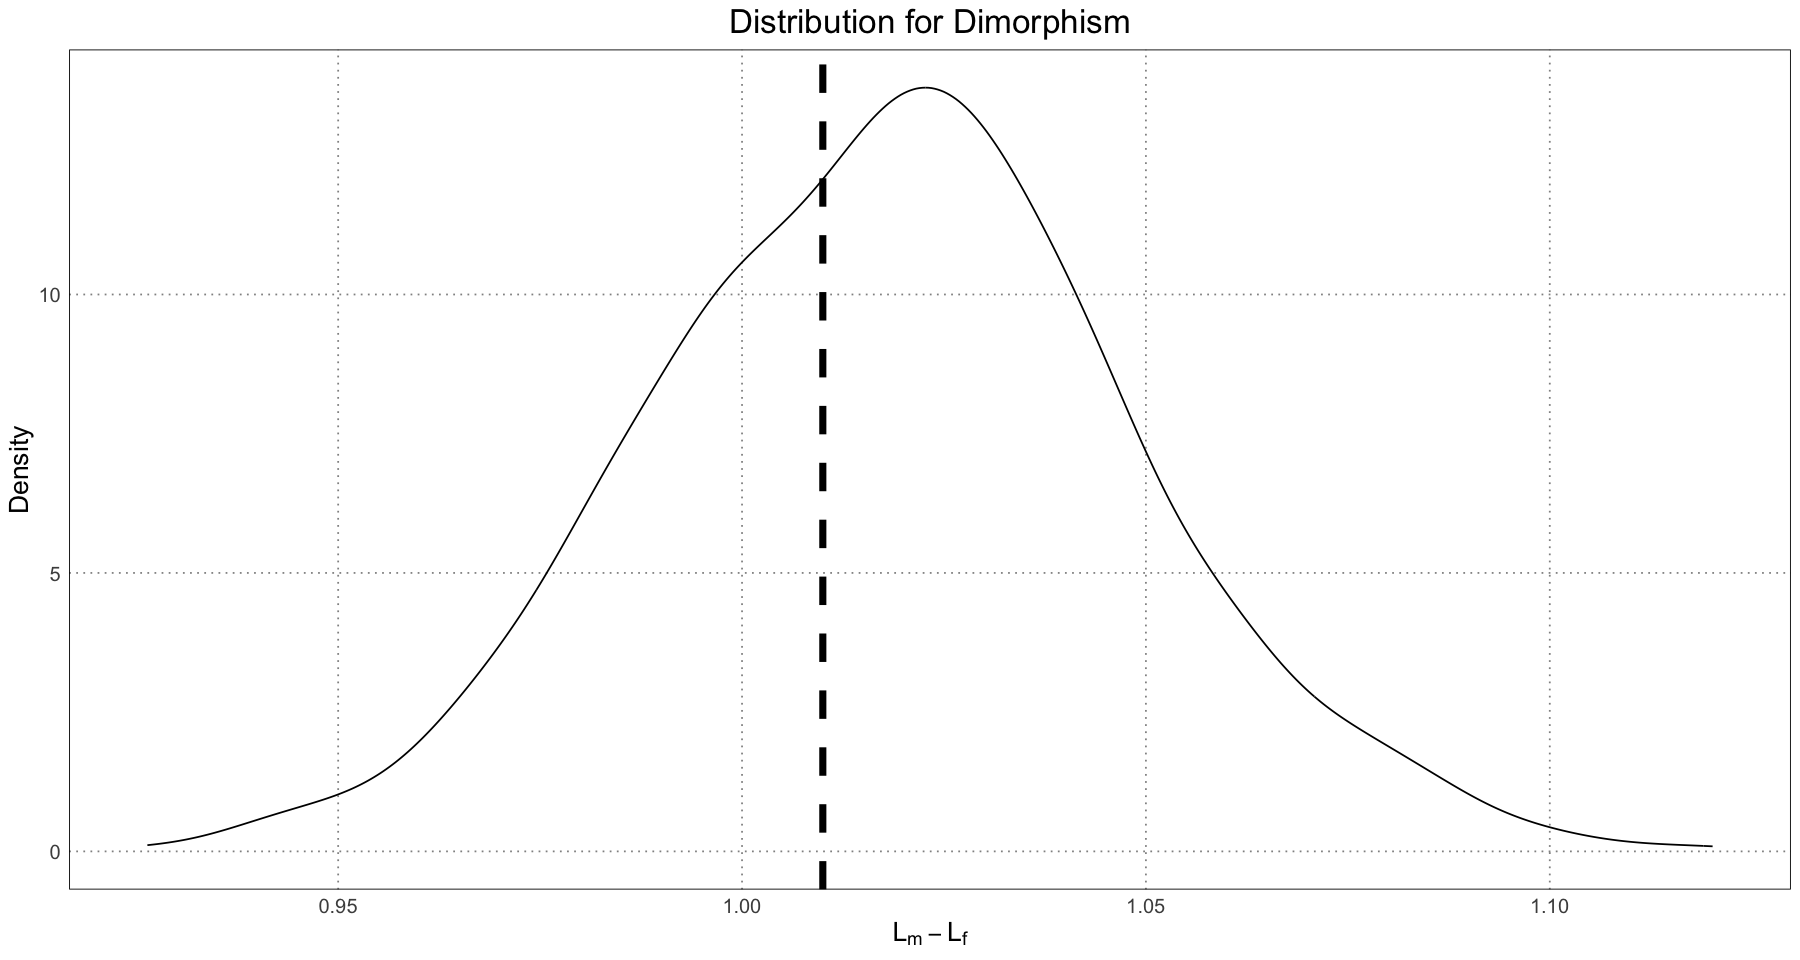

In [24]:
num_bootstrap_samples <- 1e3
female_sample <- extract(model.female)
male_sample <- extract(model.male)

female_bootstrap_L <- sample(female_sample[['L']], num_bootstrap_samples, replace = TRUE)
male_bootstrap_L <- sample(male_sample[['L']], num_bootstrap_samples, replace = TRUE)
bootstrap_diff <- male_bootstrap_L - female_bootstrap_L

ggplot(data.frame(x = bootstrap_diff), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['L']] - actual_female_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = expression(L[m] - L[f]), y = "Density", title = "Distribution for Dimorphism") +
    custom_theme()

Great! So our value for the expected level of dimorphism is right where we expect it to be.

Now let's see what happens when we change the sample size. After all, 1000 samples of each sex would be extremely unusual when looking at extinct creatures. For now, we'll focus on just the $L$ parameter and see what happens as we vary the sample size.

In [29]:
sample_sizes <- c(2, 5, 10, 15, 20, 30, 50, 100)
L_param_data <- data.frame(
    sample_size = numeric(),
    lower = numeric(),
    mu = numeric(),
    upper = numeric()
)
for (sample_size in sample_sizes) {
    sample_ages <- runif(sample_size, 1, ALLIGATOR_MAX_LIFESPAN)
    sample_lengths <- rnorm(sample_size, mean = generalized_von_bertalanffy(sample_ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']]), sd = sigma)
    male_data <- list(
        N = sample_size,
        age = c(sample_ages),
        length = c(sample_lengths)
    )
    model.male <- stan(model_code = population_prior_model, data = male_data, iter = 16000)
    male_sample <- extract(model.male)
    L_sample <- male_sample[['L']]
    instance_data <- data.frame(
        sample_size = sample_size,
        lower = quantile(L_sample, 0.025),
        mu = mean(L_sample),
        upper = quantile(L_sample, 0.975)
    )
    L_param_data <- rbind(L_param_data, instance_data)
}
L_param_data

Warning message:
“There were 7 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 106 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


,sample_size,lower,mu,upper
,<dbl>,<dbl>,<dbl>,<dbl>
2.5%,2,3.159354,3.627706,4.204827
2.5%1,5,3.070633,3.480772,4.033631
2.5%2,10,3.457944,3.722473,4.057236
2.5%3,15,3.545777,3.811182,4.125436
2.5%4,20,3.517492,3.836659,4.226520
2.5%5,30,3.384949,3.629685,3.938110
2.5%6,50,3.532951,3.690575,3.872694
2.5%7,100,3.600728,3.742852,3.904505


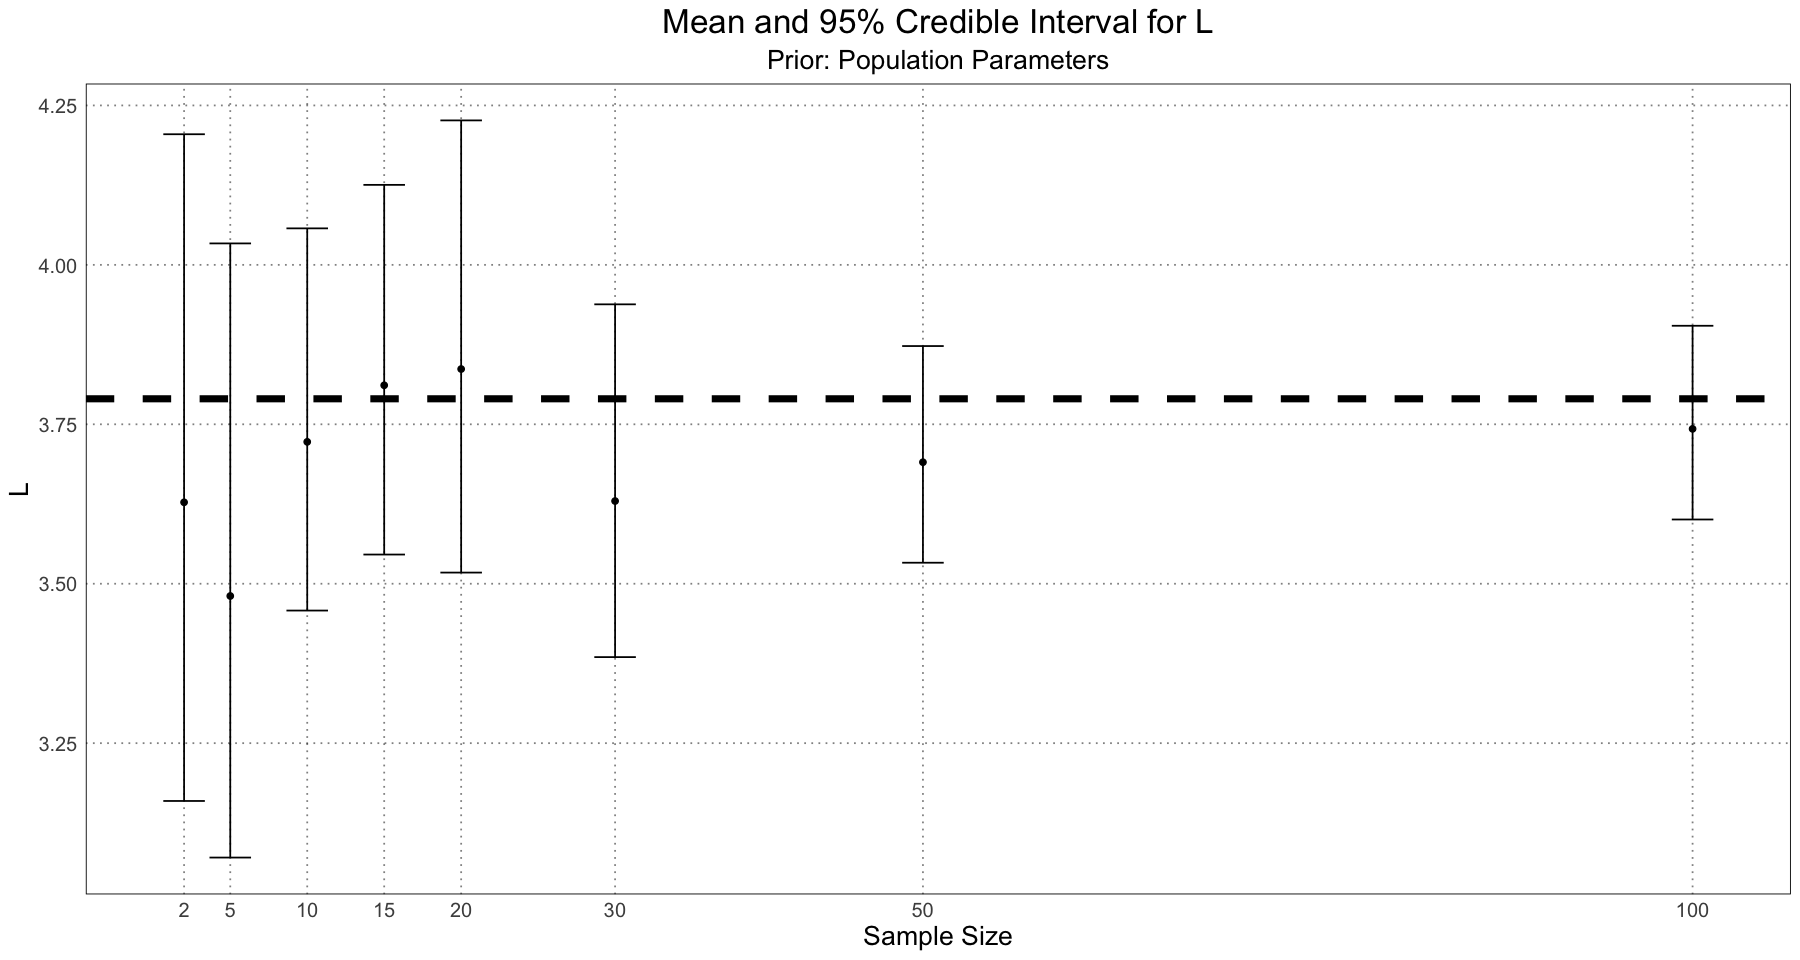

In [30]:

ggplot(L_param_data, aes(sample_size)) +
    geom_point(aes(y = mu)) +
    geom_errorbar(aes(ymin = lower, ymax = upper)) +
    geom_hline(yintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "Sample Size", y = "L", title = "Mean and 95% Credible Interval for L", subtitle = "Prior: Population Parameters") +
    scale_x_continuous(breaks = sample_sizes, labels = sample_sizes) +
    custom_theme()

As expected, we see that generally we are getting closer to our true value and with tighter bounds on the credible interval as the number of samples increases.

Of course, that is assuming that our sex assignment is perfectly accurate. Let's take a look at what happens when we use our naive classifier for predicting the sex. For this case we'll actually need to modify the model to take into account both the male and female populations (we'll calculate them both all in one go) as well as to vary the priors to be equal to the population priors. We'll just change the posterior means, not the standard deviations.

In [42]:
generate_alligator_ages <- function(num) {
    runif(num, 1, ALLIGATOR_MAX_LIFESPAN)
}

generate_actual_female_sample <- function(ages) {
    means <- generalized_von_bertalanffy(ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])
    rnorm(length(ages), mean = means, sd = 0.5)
}

generate_actual_male_sample <- function(ages) {
    means <- generalized_von_bertalanffy(ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
    rnorm(length(ages), mean = means, sd = 0.5)
}

generate_curve_fit <- function(data) {
    start <- generate_initial_vb_params(data)
    fit <- nlsLM(length ~ generalized_von_bertalanffy(age, L, A, K), data = data, start = start)
    fit
}

In [43]:
L_param_data <- data.frame(
    sample_size = numeric(),
    lower = numeric(),
    mu = numeric(),
    upper = numeric()
)
sample_sizes <- c(100)
for (sample_size in sample_sizes) {
    male_ages <- generate_alligator_ages(sample_size)
    male_lengths <- generate_actual_male_sample(male_ages)
    female_ages <- generate_alligator_ages(sample_size)
    female_lengths <- generate_actual_female_sample(female_ages)
    combined_data <- data.frame(age = c(male_ages, female_ages), length = c(male_lengths, female_lengths), sex = rep(c("M", "F"), each = sample_size))

    # fit to the population
    fit.population <- generate_curve_fit(combined_data)
    population_prior_model <- "
    data {
        int<lower = 0> N; // number of samples
        vector[N] length; // a vector of the lengths
        vector[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])
        
        // prior means for the parameters
        real prior_L_mean;
        real prior_A_mean;
        real prior_K_mean;
    }

    parameters {
        real<lower = 0> L;
        real<lower = 0> A;
        real<lower = 0> K;
        real<lower = 0> sigma_length;
    }

    model {
        vector[N] mean_length;

        L ~ normal(prior_L_mean, 0.5);
        K ~ normal(prior_K_mean, 0.025);
        A ~ normal(prior_A_mean, 0.25);
        sigma_length ~ normal(0.25, 0.0625);
        mean_length = L * (1 - A * exp(-K * age));
        length ~ normal(mean_length, sigma_length);
    }
    "
    TODO finish the male and female data and actually run the model
    male_data <- list(
        N = sample_size,
        age = c(sample_ages),
        length = c(sample_lengths),
        prior_L_mean = coefficients.population[['L']],
        prior_A_mean = coefficients.population[['A']],
        prior_K_mean = coefficients.population[['K']]
    )
    model.male <- stan(model_code = population_prior_model, data = male_data, iter = 16000)
    male_sample <- extract(model.male)
    L_sample <- male_sample[['L']]
    instance_data <- data.frame(
        sample_size = sample_size,
        lower = quantile(L_sample, 0.025),
        mu = mean(L_sample),
        upper = quantile(L_sample, 0.975)
    )
    L_param_data <- rbind(L_param_data, instance_data)
}
L_param_data

Nonlinear regression model
  model: length ~ generalized_von_bertalanffy(age, L, A, K)
   data: data
      L       K       A 
3.65399 0.05834 0.92855 
 residual sum-of-squares: 55.39

Number of iterations to convergence: 8 
Achieved convergence tolerance: 1.49e-08


sample_size,lower,mu,upper
<dbl>,<dbl>,<dbl>,<dbl>


The next thing we should examine is how good we are at recovering the actual level of dimorphism. To do this, let's generate different samples from simulated male and female populations with true levels of dimorphism ranging from 0 to twice the actual amount seen in nature. Again, we're going to keep the standard deviation constant for simplicity.

In [44]:
generate_male_params_from_effect_size <- function(E) {
    list(
        L = actual_female_params[['L']] + E * (actual_male_params[['L']] - actual_female_params[['L']]),
        A = actual_female_params[['A']] + E * (actual_male_params[['A']] - actual_female_params[['A']]),
        K = actual_female_params[['K']] + E * (actual_male_params[['K']] - actual_female_params[['K']])
    )
}

generate_male_sample <- function(ages, E) {
    params <- generate_male_params_from_effect_size(E)
    means <- generalized_von_bertalanffy(ages, L = params[['L']], A = params[['A']], K = params[['K']])
    rnorm(length(ages), mean = means, sd = 0.5)
}


generate_difference <- function(sample1, sample2, sample_size) {
    bootstrap_sample1 <- sample(sample1, size = sample_size, replace = FALSE)
    bootstrap_sample2 <- sample(sample2, size = sample_size, replace = FALSE)
    bootstrap_sample1 - bootstrap_sample2
}